### installtions

In [1]:
# !pip install scikit-learn

### imports

In [2]:
import os
import time
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, AdamW
# import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from datetime import datetime
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

### paths & arguments

In [3]:
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, 'finetune_dataset/kge_sentiment_analysis')
# DATA_PATH = os.path.join(ROOT_PATH, '../../research_datasets/finetune_dataset/kge_sentiment_analysis')

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
DATASET = 'SST5'
# DATASET = 'SST2'

BSZ = 64
EPOCH = 500
LR = 1e-6

KOKONOMODEL = 'boomberta'
# KOKONOMODEL = 'roberta'

KOKONOTEST = '_D_' + DATASET + '_M_' + KOKONOMODEL + '_B_' + str(BSZ) + '_E_' + str(EPOCH) + '_LR_' + str(LR)
print(KOKONOTEST)

_D_SST5_M_boomberta_B_64_E_500_LR_1e-06


In [5]:
MODEL_NAME = 'roberta-large'

### some function for checking

In [6]:
def get_encodings_df_tokensaru(encodings, idx):
    ids, tokens, attention_mask = [], [], []
    i = 0

    for get_ids in encodings[idx].ids:
        ids += [get_ids]
        
    for get_tokens in encodings[idx].tokens:
        tokens += [get_tokens.replace('Ġ', '')]

    for get_attention_mask in encodings[idx].attention_mask:
        attention_mask += [get_attention_mask]
        i = i+1

    show_tokens_DF = pd.DataFrame({'ids': ids, 'tokens': tokens, 'attention_mask': attention_mask})
    print('got ' + str(i))
    return show_tokens_DF

In [7]:
# show_tokens_DF = get_encodings_df_tokensaru(test_encodings, 99)
# show_tokens_DF

In [8]:
def get_encodings_df(encodings, idx):
    input_ids, attention_mask = [], []
    i = 0

    for get_input_ids in encodings['input_ids'][idx]:
        input_ids += [get_input_ids]

    for get_attention_mask in encodings['attention_mask'][idx]:
        attention_mask += [get_attention_mask]
        i = i+1

    show_tokens_DF = pd.DataFrame({'input_ids': input_ids, 'attention_mask': attention_mask})
    print('got ' + str(i))
    return show_tokens_DF

In [9]:
# show_tokens_DF = get_encodings_df(test_encodings, 99)
# show_tokens_DF

In [10]:
def print_model_summary(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
    print(f"Total Trainable Parameters: {total_params}")

In [11]:
# print_model_summary(model)

### datasets & preprocess

In [12]:
# # Load the SST-5 dataset
dataset = pd.read_csv(DATA_PATH + '/train.tsv.zip', sep="\t")
train, valid = train_test_split(dataset, random_state=42, test_size = 0.1)

In [13]:
# train, _ = train_test_split(train, random_state=42, test_size = 0.999)
# valid, _ = train_test_split(valid, random_state=42, test_size = 0.99)

In [14]:
# Load the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

# Tokenize the dataset
def tokenize_dataset(dataset):
    encodings = tokenizer(dataset['Phrase'].tolist(), truncation=True, padding=True)
    labels = dataset['Sentiment'].tolist()
    return encodings, labels

train_encodings, train_labels = tokenize_dataset(train)
valid_encodings, valid_labels = tokenize_dataset(valid)

In [15]:
# Create a torch dataset
class TsvDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {}
        item['input_ids'] = torch.tensor(self.encodings['input_ids'][idx])
        item['attention_mask'] = torch.tensor(self.encodings['attention_mask'][idx])
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_dataset = TsvDataset(train_encodings, train_labels)
valid_dataset = TsvDataset(valid_encodings, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True, drop_last=True, generator=torch.Generator(device='cuda'))
valid_loader = DataLoader(valid_dataset, batch_size=BSZ, shuffle=True, drop_last=True, generator=torch.Generator(device='cuda'))

### boomberta import

In [17]:
import math
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from ...activations import ACT2FN, gelu
from transformers.activations import ACT2FN, gelu
# from ...modeling_outputs import (
#     BaseModelOutputWithPastAndCrossAttentions,
#     BaseModelOutputWithPoolingAndCrossAttentions,
#     CausalLMOutputWithCrossAttentions,
#     MaskedLMOutput,
#     MultipleChoiceModelOutput,
#     QuestionAnsweringModelOutput,
#     SequenceClassifierOutput,
#     TokenClassifierOutput,
# )
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)
# from ...modeling_utils import PreTrainedModel
from transformers.modeling_utils import PreTrainedModel
# from ...pytorch_utils import apply_chunking_to_forward, find_pruneable_heads_and_indices, prune_linear_layer
from transformers.pytorch_utils import apply_chunking_to_forward, find_pruneable_heads_and_indices, prune_linear_layer
# from ...utils import (
#     add_code_sample_docstrings,
#     add_start_docstrings,
#     add_start_docstrings_to_model_forward,
#     logging,
#     replace_return_docstrings,
# )
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
# from .configuration_roberta import RobertaConfig
from transformers.models.roberta.configuration_roberta import RobertaConfig

logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "roberta-base"
_CONFIG_FOR_DOC = "RobertaConfig"

ROBERTA_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "roberta-base",
    "roberta-large",
    "roberta-large-mnli",
    "distilroberta-base",
    "roberta-base-openai-detector",
    "roberta-large-openai-detector",
    # See all RoBERTa models at https://huggingface.co/models?filter=roberta
]

ROBERTA_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `({0})`):
            Indices of input sequence tokens in the vocabulary.

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.FloatTensor` of shape `({0})`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        token_type_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Segment token indices to indicate first and second portions of the inputs. Indices are selected in `[0,1]`:

            - 0 corresponds to a *sentence A* token,
            - 1 corresponds to a *sentence B* token.
            This parameter can only be used when the model is initialized with `type_vocab_size` parameter with value
            >= 2. All the value in this tensor should be always < type_vocab_size.

            [What are token type IDs?](../glossary#token-type-ids)
        position_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        head_mask (`torch.FloatTensor` of shape `(num_heads,)` or `(num_layers, num_heads)`, *optional*):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        inputs_embeds (`torch.FloatTensor` of shape `({0}, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

In [18]:
from transformers.models.roberta.modeling_roberta import (
    RobertaAttention, 
    RobertaPreTrainedModel, 
    RobertaPooler, 
    RobertaEmbeddings, 
    RobertaClassificationHead
    )
from torch import Tensor

In [19]:
class GELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)

In [20]:
class Boom_crop(nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        super(Boom_crop, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, input: Tensor) -> Tensor:
        ninp = self.out_features
        output = torch.narrow(input, -1, 0, input.shape[-1] // ninp * ninp)
        output = output.view(*output.shape[:-1], output.shape[-1] // ninp, ninp)
        output = output.sum(dim=-2)
        return output

In [21]:
class Boom_Layer(nn.Module):
    def __init__(self, in_features: int, mid_features: int, dropout=0.1) -> None:
        super(Boom_Layer, self).__init__()

        self.up_linear = nn.Linear(in_features, mid_features)
        self.boom_crop = Boom_crop(mid_features, in_features)

        self.act = GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, input: Tensor) -> Tensor:

        output = self.up_linear(input)
        output = self.act(output)
        output = self.dropout(output)

        output = self.boom_crop(output)

        return output

In [22]:
class RobertaIntermediateAndBoom(nn.Module):
    def __init__(self, config):
        super().__init__()
        # self.dense_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        # if isinstance(config.hidden_act, str):
        #     self.intermediate_act_fn = ACT2FN[config.hidden_act]
        # else:
        #     self.intermediate_act_fn = config.hidden_act

        # self.dense_2 = nn.Linear(config.intermediate_size, config.hidden_size)

        self.boom = Boom_Layer(config.hidden_size, config.intermediate_size)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # hidden_states = self.dense_1(input_tensor)
        # hidden_states = self.intermediate_act_fn(hidden_states)

        # hidden_states = self.dense_2(hidden_states)

        hidden_states = self.boom(input_tensor)

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states

In [23]:
class ModifiedRobertaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = RobertaAttention(config)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            if not self.is_decoder:
                raise ValueError(f"{self} should be used as a decoder model if cross attention is added")
            self.crossattention = RobertaAttention(config, position_embedding_type="absolute")
        # self.intermediate = RobertaIntermediate(config)#####
        # self.output = RobertaOutput(config)#####
        
        self.intermediateandboom = RobertaIntermediateAndBoom(config)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            outputs = self_attention_outputs[1:-1]
            present_key_value = self_attention_outputs[-1]
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None:
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with cross-attention layers"
                    " by setting `config.add_cross_attention=True`"
                )

            # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            cross_attention_outputs = self.crossattention(
                attention_output,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                cross_attn_past_key_value,
                output_attentions,
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

            # add cross-attn cache to positions 3,4 of present_key_value tuple
            cross_attn_present_key_value = cross_attention_outputs[-1]
            present_key_value = present_key_value + cross_attn_present_key_value

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder:
            outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        # print(attention_output.shape)
        # intermediate_output = self.intermediate(attention_output)
        # print(intermediate_output.shape)
        # layer_output = self.output(intermediate_output, attention_output)
        # print(layer_output.shape)

        layer_output = self.intermediateandboom(attention_output)

        return layer_output

In [24]:
class ModifiedRobertaEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([ModifiedRobertaLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

In [25]:
class ModifiedRobertaModel(RobertaPreTrainedModel):
    """

    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in *Attention is
    all you need*_ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz
    Kaiser and Illia Polosukhin.

    To behave as an decoder the model needs to be initialized with the `is_decoder` argument of the configuration set
    to `True`. To be used in a Seq2Seq model, the model needs to initialized with both `is_decoder` argument and
    `add_cross_attention` set to `True`; an `encoder_hidden_states` is then expected as an input to the forward pass.

    .. _*Attention is all you need*: https://arxiv.org/abs/1706.03762

    """

    _keys_to_ignore_on_load_missing = [r"position_ids"]

    # Copied from transformers.models.bert.modeling_bert.BertModel.__init__ with Bert->Roberta
    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = RobertaEmbeddings(config)
        self.encoder = ModifiedRobertaEncoder(config)

        self.pooler = RobertaPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=BaseModelOutputWithPoolingAndCrossAttentions,
        config_class=_CONFIG_FOR_DOC,
    )
    # Copied from transformers.models.bert.modeling_bert.BertModel.forward
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
        r"""
        encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )

In [26]:
class ModifiedRobertaForSequenceClassification(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.roberta = ModifiedRobertaModel(config, add_pooling_layer=False)
        self.classifier = RobertaClassificationHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint="cardiffnlp/twitter-roberta-base-emotion",
        output_type=SequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output="'optimism'",
        expected_loss=0.08,
    )
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### model

In [27]:
print(KOKONOMODEL)

boomberta


In [28]:
# if KOKONOMODEL == 'roberta':
#     model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
# elif KOKONOMODEL == 'boomberta':
#     model = ModifiedRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

Some weights of the model checkpoint at roberta-large were not used when initializing ModifiedRobertaForSequenceClassification: ['roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.9.intermediate.dense.weight', 'roberta.encoder.layer.10.intermediate.dense.weight', 'roberta.encoder.layer.12.output.dense.weight', 'roberta.encoder.layer.12.output.dense.bias', 'roberta.encoder.layer.9.output.dense.weight', 'roberta.encoder.layer.19.intermediate.dense.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.dense.weight', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'lm_head.layer_norm.weight', 'roberta.encoder.layer.12.output.LayerNorm.weight', 'roberta.encoder.layer.19.output.LayerNorm.weight', 'roberta.encoder.layer.8.intermediate.dense.weight', 'roberta.encoder.layer.6.intermediate.dense.weight', 'roberta.encoder.layer.5.output.LayerNorm.weight', 'roberta.encoder.layer.7.intermed

In [ ]:
model = ModifiedRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5, num_hidden_layers=42)

In [29]:
print_model_summary(model)

Total Trainable Parameters: 254603269


In [30]:
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False

for i in range(24):#len(model.roberta.encoder.layer)):
    for param in model.roberta.encoder.layer[i].attention.parameters():
        param.requires_grad = False

In [31]:
print_model_summary(model)

Total Trainable Parameters: 101791749


### training

In [32]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model, train_loader, valid_loader, num_epochs, lr, device=torch.device("cuda:0")):
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        cudnn.benchmark = True
        self.best_loss = float("inf")
        self.phases = ["train", "valid"]

        self.device = device
        self.dataloaders = {self.phases[0]: train_loader, self.phases[1]: valid_loader}
    
        self.lr = lr
        self.num_epochs = num_epochs
        # self.accumulation_steps = 32 // self.dataloaders['train'].batch_size
        
        self.model = model.to(self.device)
        self.optimizer = AdamW(model.parameters(), lr=1e-5)
        # self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        
        self.losses =   {phase: [] for phase in self.phases}
        self.accuracy = {phase: [] for phase in self.phases}
        self.epoch_losses = {phase: [] for phase in self.phases}
        self.epoch_accuracy = {phase: [] for phase in self.phases}

    def iterate(self, epoch, phase):
        step_loss = []
        step_acc = []
        nowtime = time.strftime("%H:%M:%S")

        if phase == "train":
            self.model.train()
        else:
            self.model.eval()
        dataloader = self.dataloaders[phase]
        # running_losses = []
        # total_batches = len(dataloader)

        self.optimizer.zero_grad()
        pbar = tqdm(dataloader, total=len(dataloader), position=0, leave=True, desc=f"[{nowtime}] type: {phase} epoch {epoch}")
        for itr, batch in enumerate(pbar):
            batch = {key: value.to(self.device) for key, value in batch.items()}
            outputs = self.model(**batch)
            loss = outputs.loss

            if phase == "train":
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            # loss = loss / self.accumulation_steps
            # if phase == "train":
            #     loss.backward()
            #     if (itr + 1 ) % self.accumulation_steps == 0:
            #         self.optimizer.step()
            #         self.optimizer.zero_grad()

            step_loss += [loss.item()]

            _, predictions = outputs['logits'].max(1)
            label = batch['labels']
            step_acc += [(((predictions == label).sum())/(predictions.size(0))).item()]

        # epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        
        self.losses[phase] = self.losses[phase] + step_loss
        self.accuracy[phase] = self.accuracy[phase] + step_acc

        epoch_loss = sum(step_loss)/len(step_loss)
        epoch_accuracy = sum(step_acc)/len(step_acc)
        
        self.epoch_losses[phase] += [epoch_loss]
        self.epoch_accuracy[phase] += [epoch_accuracy]

        print("avg_loss: %0.4f | avg_acc: %0.4f" % (epoch_loss, epoch_accuracy))

        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
                'model': model,
            }

            valid_loss = self.iterate(epoch, "valid")
            # self.scheduler.step(valid_loss)
            if valid_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = valid_loss
                nowtime = datetime.now().strftime("%y%m%d%H%M")
                torch.save(state, "./" + nowtime + '_loss_' + str(valid_loss) + KOKONOTEST + ".pth")
            print()

In [33]:
model_trainer = Trainer(model, train_loader, valid_loader, EPOCH, LR, device)
model_trainer.start()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
[05:34:28] type: valid epoch 0:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.3306 | avg_acc: 0.4963


[05:34:28] type: valid epoch 0: 100%|██████████| 243/243 [00:32<00:00,  7.38it/s]


avg_loss: 1.3634 | avg_acc: 0.5004
******** New optimal found, saving state ********


[05:35:08] type: train epoch 1:   0%|          | 0/2194 [00:00<?, ?it/s]

[05:50:13] type: valid epoch 1:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.3009 | avg_acc: 0.5096


[05:50:13] type: valid epoch 1: 100%|██████████| 243/243 [00:33<00:00,  7.35it/s]


avg_loss: 1.3034 | avg_acc: 0.4999
******** New optimal found, saving state ********


[05:50:53] type: train epoch 2:   0%|          | 0/2194 [00:00<?, ?it/s]

[06:05:57] type: valid epoch 2:   0%|          | 1/243 [00:00<00:32,  7.36it/s]

avg_loss: 1.2939 | avg_acc: 0.5099


[06:05:57] type: valid epoch 2: 100%|██████████| 243/243 [00:33<00:00,  7.35it/s]


avg_loss: 1.2927 | avg_acc: 0.5006
******** New optimal found, saving state ********


[06:06:37] type: train epoch 3:   0%|          | 0/2194 [00:00<?, ?it/s]

[06:21:42] type: valid epoch 3:   0%|          | 1/243 [00:00<00:31,  7.67it/s]

avg_loss: 1.2928 | avg_acc: 0.5103


[06:21:42] type: valid epoch 3: 100%|██████████| 243/243 [00:33<00:00,  7.35it/s]


avg_loss: 1.2855 | avg_acc: 0.4999
******** New optimal found, saving state ********


[06:22:23] type: train epoch 4:   0%|          | 0/2194 [00:00<?, ?it/s]

[06:37:26] type: valid epoch 4:   0%|          | 1/243 [00:00<00:33,  7.17it/s]

avg_loss: 1.2904 | avg_acc: 0.5103


[06:38:00] type: train epoch 5:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2964 | avg_acc: 0.5001



[06:53:05] type: valid epoch 5:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2878 | avg_acc: 0.5105


[06:53:38] type: train epoch 6:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2949 | avg_acc: 0.5003



[07:08:44] type: valid epoch 6:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2869 | avg_acc: 0.5106


[07:09:17] type: train epoch 7:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2973 | avg_acc: 0.4999



[07:24:22] type: valid epoch 7:   0%|          | 1/243 [00:00<00:31,  7.66it/s]

avg_loss: 1.2850 | avg_acc: 0.5104


[07:24:56] type: train epoch 8:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3091 | avg_acc: 0.5003



[07:40:04] type: valid epoch 8:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2852 | avg_acc: 0.5106


[07:40:38] type: train epoch 9:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3053 | avg_acc: 0.5000



[07:55:45] type: valid epoch 9:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2828 | avg_acc: 0.5107


[07:56:19] type: train epoch 10:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3026 | avg_acc: 0.5005



[08:11:29] type: valid epoch 10:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2827 | avg_acc: 0.5108


[08:12:02] type: train epoch 11:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3084 | avg_acc: 0.5001



[08:27:09] type: valid epoch 11:   0%|          | 1/243 [00:00<00:32,  7.35it/s]

avg_loss: 1.2817 | avg_acc: 0.5109


[08:27:42] type: train epoch 12:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3106 | avg_acc: 0.5001



[08:42:51] type: valid epoch 12:   0%|          | 1/243 [00:00<00:33,  7.13it/s]

avg_loss: 1.2806 | avg_acc: 0.5108


[08:43:24] type: train epoch 13:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3283 | avg_acc: 0.4994



[08:43:24] type: train epoch 13: 100%|██████████| 2194/2194 [15:07<00:00,  2.42it/s]


avg_loss: 1.2801 | avg_acc: 0.5109


[08:59:05] type: train epoch 14:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3533 | avg_acc: 0.4953



[09:14:15] type: valid epoch 14:   0%|          | 1/243 [00:00<00:31,  7.56it/s]

avg_loss: 1.2802 | avg_acc: 0.5108


[09:14:48] type: train epoch 15:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3081 | avg_acc: 0.5005



[09:30:00] type: valid epoch 15:   0%|          | 1/243 [00:00<00:32,  7.41it/s]

avg_loss: 1.2788 | avg_acc: 0.5107


[09:30:33] type: train epoch 16:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3719 | avg_acc: 0.4794



[09:45:45] type: valid epoch 16:   0%|          | 1/243 [00:00<00:31,  7.74it/s]

avg_loss: 1.2794 | avg_acc: 0.5109


[09:46:18] type: train epoch 17:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3475 | avg_acc: 0.4924



[10:01:28] type: valid epoch 17:   0%|          | 1/243 [00:00<00:33,  7.14it/s]

avg_loss: 1.2773 | avg_acc: 0.5109


[10:02:02] type: train epoch 18:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3502 | avg_acc: 0.4990



[10:17:12] type: valid epoch 18:   0%|          | 1/243 [00:00<00:33,  7.18it/s]

avg_loss: 1.2777 | avg_acc: 0.5109


[10:17:45] type: train epoch 19:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3368 | avg_acc: 0.4985



[10:32:53] type: valid epoch 19:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2754 | avg_acc: 0.5109


[10:33:26] type: train epoch 20:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3393 | avg_acc: 0.5003



[10:48:35] type: valid epoch 20:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2762 | avg_acc: 0.5108


[10:49:09] type: train epoch 21:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3480 | avg_acc: 0.5001



[11:04:16] type: valid epoch 21:   0%|          | 1/243 [00:00<00:33,  7.17it/s]

avg_loss: 1.2758 | avg_acc: 0.5110


[11:04:49] type: train epoch 22:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3578 | avg_acc: 0.4962



[11:19:54] type: valid epoch 22:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2757 | avg_acc: 0.5111


[11:20:27] type: train epoch 23:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3503 | avg_acc: 0.4972



[11:35:33] type: valid epoch 23:   0%|          | 1/243 [00:00<00:33,  7.29it/s]

avg_loss: 1.2749 | avg_acc: 0.5110


[11:36:06] type: train epoch 24:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3560 | avg_acc: 0.4996



[11:51:13] type: valid epoch 24:   0%|          | 1/243 [00:00<00:31,  7.69it/s]

avg_loss: 1.2748 | avg_acc: 0.5110


[11:51:46] type: train epoch 25:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3618 | avg_acc: 0.4952



[12:06:52] type: valid epoch 25:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2742 | avg_acc: 0.5108


[12:07:25] type: train epoch 26:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3445 | avg_acc: 0.5000



[12:22:31] type: valid epoch 26:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2743 | avg_acc: 0.5110


[12:23:05] type: train epoch 27:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3356 | avg_acc: 0.5006



[12:38:12] type: valid epoch 27:   0%|          | 1/243 [00:00<00:31,  7.73it/s]

avg_loss: 1.2725 | avg_acc: 0.5110


[12:38:45] type: train epoch 28:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3451 | avg_acc: 0.4986



[12:53:51] type: valid epoch 28:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2734 | avg_acc: 0.5110


[12:54:24] type: train epoch 29:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3680 | avg_acc: 0.4972



[12:54:24] type: train epoch 29: 100%|██████████| 2194/2194 [15:04<00:00,  2.43it/s]


avg_loss: 1.2714 | avg_acc: 0.5109


[13:10:02] type: train epoch 30:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3760 | avg_acc: 0.4785



[13:25:08] type: valid epoch 30:   0%|          | 1/243 [00:00<00:35,  6.88it/s]

avg_loss: 1.2721 | avg_acc: 0.5110


[13:25:41] type: train epoch 31:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3765 | avg_acc: 0.4974



[13:40:46] type: valid epoch 31:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2719 | avg_acc: 0.5109


[13:41:19] type: train epoch 32:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3342 | avg_acc: 0.5001



[13:56:24] type: valid epoch 32:   0%|          | 1/243 [00:00<00:31,  7.68it/s]

avg_loss: 1.2716 | avg_acc: 0.5111


[13:56:57] type: train epoch 33:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3688 | avg_acc: 0.4793



[14:12:00] type: valid epoch 33:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2710 | avg_acc: 0.5111


[14:12:34] type: train epoch 34:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3525 | avg_acc: 0.4988



[14:27:37] type: valid epoch 34:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2708 | avg_acc: 0.5110


[14:28:11] type: train epoch 35:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3501 | avg_acc: 0.4976



[14:43:14] type: valid epoch 35:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2699 | avg_acc: 0.5111


[14:43:47] type: train epoch 36:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3536 | avg_acc: 0.4981



[14:58:50] type: valid epoch 36:   0%|          | 1/243 [00:00<00:33,  7.30it/s]

avg_loss: 1.2694 | avg_acc: 0.5109


[14:59:23] type: train epoch 37:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3632 | avg_acc: 0.4950



[15:14:27] type: valid epoch 37:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2686 | avg_acc: 0.5110


[15:15:00] type: train epoch 38:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3533 | avg_acc: 0.4993



[15:30:02] type: valid epoch 38:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2687 | avg_acc: 0.5109


[15:30:35] type: train epoch 39:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3631 | avg_acc: 0.4959



[15:45:37] type: valid epoch 39:   0%|          | 1/243 [00:00<00:31,  7.72it/s]

avg_loss: 1.2685 | avg_acc: 0.5109


[15:46:10] type: train epoch 40:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3576 | avg_acc: 0.4994



[16:01:14] type: valid epoch 40:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2687 | avg_acc: 0.5112


[16:01:47] type: train epoch 41:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3490 | avg_acc: 0.4986



[16:16:52] type: valid epoch 41:   0%|          | 1/243 [00:00<00:33,  7.16it/s]

avg_loss: 1.2676 | avg_acc: 0.5111


[16:17:25] type: train epoch 42:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3367 | avg_acc: 0.5001



[16:32:29] type: valid epoch 42:   0%|          | 1/243 [00:00<00:31,  7.65it/s]

avg_loss: 1.2675 | avg_acc: 0.5109


[16:33:02] type: train epoch 43:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3728 | avg_acc: 0.4993



[16:48:05] type: valid epoch 43:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2672 | avg_acc: 0.5113


[16:48:38] type: train epoch 44:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3540 | avg_acc: 0.4986



[17:03:40] type: valid epoch 44:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2668 | avg_acc: 0.5110


[17:04:13] type: train epoch 45:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3733 | avg_acc: 0.4966



[17:19:14] type: valid epoch 45:   0%|          | 1/243 [00:00<00:33,  7.20it/s]

avg_loss: 1.2658 | avg_acc: 0.5111


[17:19:47] type: train epoch 46:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3724 | avg_acc: 0.4981



[17:34:50] type: valid epoch 46:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2662 | avg_acc: 0.5111


[17:35:23] type: train epoch 47:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3673 | avg_acc: 0.4952



[17:50:26] type: valid epoch 47:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2653 | avg_acc: 0.5111


[17:50:59] type: train epoch 48:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3602 | avg_acc: 0.4964



[18:06:02] type: valid epoch 48:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2646 | avg_acc: 0.5109


[18:06:35] type: train epoch 49:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3520 | avg_acc: 0.4988



[18:21:39] type: valid epoch 49:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2640 | avg_acc: 0.5113


[18:22:12] type: train epoch 50:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3720 | avg_acc: 0.4871



[18:37:18] type: valid epoch 50:   0%|          | 1/243 [00:00<00:34,  7.06it/s]

avg_loss: 1.2639 | avg_acc: 0.5110


[18:37:51] type: train epoch 51:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3699 | avg_acc: 0.4889



[18:52:54] type: valid epoch 51:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2638 | avg_acc: 0.5112


[18:53:27] type: train epoch 52:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3670 | avg_acc: 0.4912



[19:08:32] type: valid epoch 52:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2632 | avg_acc: 0.5110


[19:09:05] type: train epoch 53:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3623 | avg_acc: 0.4959



[19:24:09] type: valid epoch 53:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2626 | avg_acc: 0.5110


[19:24:42] type: train epoch 54:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3753 | avg_acc: 0.4511



[19:39:44] type: valid epoch 54:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2619 | avg_acc: 0.5110


[19:40:17] type: train epoch 55:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3719 | avg_acc: 0.4762



[19:55:18] type: valid epoch 55:   0%|          | 1/243 [00:00<00:35,  6.78it/s]

avg_loss: 1.2621 | avg_acc: 0.5110


[19:55:51] type: train epoch 56:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3755 | avg_acc: 0.4891



[20:10:53] type: valid epoch 56:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2614 | avg_acc: 0.5111


[20:11:26] type: train epoch 57:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3858 | avg_acc: 0.4883



[20:26:27] type: valid epoch 57:   0%|          | 1/243 [00:00<00:32,  7.40it/s]

avg_loss: 1.2608 | avg_acc: 0.5111


[20:27:00] type: train epoch 58:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3548 | avg_acc: 0.4917



[20:42:01] type: valid epoch 58:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2600 | avg_acc: 0.5109


[20:42:34] type: train epoch 59:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3861 | avg_acc: 0.4573



[20:57:35] type: valid epoch 59:   0%|          | 1/243 [00:00<00:33,  7.18it/s]

avg_loss: 1.2607 | avg_acc: 0.5113


[20:58:07] type: train epoch 60:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3469 | avg_acc: 0.4967



[20:58:07] type: train epoch 60: 100%|██████████| 2194/2194 [15:03<00:00,  2.43it/s]


avg_loss: 1.2599 | avg_acc: 0.5112


[21:13:44] type: train epoch 61:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3651 | avg_acc: 0.4810



[21:28:48] type: valid epoch 61:   0%|          | 1/243 [00:00<00:32,  7.38it/s]

avg_loss: 1.2599 | avg_acc: 0.5112


[21:29:21] type: train epoch 62:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3465 | avg_acc: 0.4995



[21:44:26] type: valid epoch 62:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2584 | avg_acc: 0.5106


[21:44:59] type: train epoch 63:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3460 | avg_acc: 0.4948



[22:00:03] type: valid epoch 63:   0%|          | 1/243 [00:00<00:33,  7.24it/s]

avg_loss: 1.2577 | avg_acc: 0.5115


[22:00:36] type: train epoch 64:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3682 | avg_acc: 0.4864



[22:15:38] type: valid epoch 64:   0%|          | 1/243 [00:00<00:36,  6.61it/s]

avg_loss: 1.2579 | avg_acc: 0.5115


[22:16:11] type: train epoch 65:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3432 | avg_acc: 0.4939



[22:31:12] type: valid epoch 65:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2577 | avg_acc: 0.5112


[22:31:45] type: train epoch 66:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3393 | avg_acc: 0.4936



[22:46:47] type: valid epoch 66:   0%|          | 1/243 [00:00<00:31,  7.73it/s]

avg_loss: 1.2573 | avg_acc: 0.5116


[22:47:20] type: train epoch 67:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3612 | avg_acc: 0.4943



[23:02:21] type: valid epoch 67:   0%|          | 1/243 [00:00<00:32,  7.35it/s]

avg_loss: 1.2560 | avg_acc: 0.5115


[23:02:54] type: train epoch 68:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3397 | avg_acc: 0.4968



[23:17:54] type: valid epoch 68:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2556 | avg_acc: 0.5108


[23:18:27] type: train epoch 69:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3334 | avg_acc: 0.4927



[23:33:29] type: valid epoch 69:   0%|          | 1/243 [00:00<00:37,  6.47it/s]

avg_loss: 1.2559 | avg_acc: 0.5113


[23:34:02] type: train epoch 70:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3238 | avg_acc: 0.5003



[23:49:03] type: valid epoch 70:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2572 | avg_acc: 0.5111


[23:49:36] type: train epoch 71:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3181 | avg_acc: 0.5008



[00:04:36] type: valid epoch 71:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2554 | avg_acc: 0.5114


[00:05:10] type: train epoch 72:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3293 | avg_acc: 0.4960



[00:20:13] type: valid epoch 72:   0%|          | 1/243 [00:00<00:31,  7.72it/s]

avg_loss: 1.2550 | avg_acc: 0.5110


[00:20:46] type: train epoch 73:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3287 | avg_acc: 0.5006



[00:35:50] type: valid epoch 73:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2544 | avg_acc: 0.5113


[00:36:23] type: train epoch 74:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3546 | avg_acc: 0.4799



[00:51:27] type: valid epoch 74:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2537 | avg_acc: 0.5108


[00:52:00] type: train epoch 75:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3284 | avg_acc: 0.4982



[01:07:04] type: valid epoch 75:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2534 | avg_acc: 0.5118


[01:07:37] type: train epoch 76:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3262 | avg_acc: 0.4998



[01:22:38] type: valid epoch 76:   0%|          | 1/243 [00:00<00:34,  7.03it/s]

avg_loss: 1.2538 | avg_acc: 0.5116


[01:23:11] type: train epoch 77:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3407 | avg_acc: 0.4980



[01:38:12] type: valid epoch 77:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2529 | avg_acc: 0.5114


[01:38:45] type: train epoch 78:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3321 | avg_acc: 0.4966



[01:38:45] type: train epoch 78: 100%|██████████| 2194/2194 [15:01<00:00,  2.43it/s]


avg_loss: 1.2529 | avg_acc: 0.5110


[01:54:20] type: train epoch 79:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3308 | avg_acc: 0.4979



[02:09:22] type: valid epoch 79:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2528 | avg_acc: 0.5111


[02:09:56] type: train epoch 80:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3269 | avg_acc: 0.5001



[02:25:00] type: valid epoch 80:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2518 | avg_acc: 0.5110


[02:25:33] type: train epoch 81:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3184 | avg_acc: 0.4983



[02:40:37] type: valid epoch 81:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2520 | avg_acc: 0.5113


[02:41:10] type: train epoch 82:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3278 | avg_acc: 0.4974



[02:56:16] type: valid epoch 82:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2524 | avg_acc: 0.5115


[02:56:49] type: train epoch 83:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3314 | avg_acc: 0.5003



[03:11:56] type: valid epoch 83:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2512 | avg_acc: 0.5111


[03:12:29] type: train epoch 84:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3183 | avg_acc: 0.4995



[03:27:35] type: valid epoch 84:   0%|          | 1/243 [00:00<00:31,  7.65it/s]

avg_loss: 1.2513 | avg_acc: 0.5112


[03:28:08] type: train epoch 85:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3062 | avg_acc: 0.5002



[03:43:16] type: valid epoch 85:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2505 | avg_acc: 0.5114


[03:43:49] type: train epoch 86:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3259 | avg_acc: 0.4964



[03:58:57] type: valid epoch 86:   0%|          | 1/243 [00:00<00:32,  7.41it/s]

avg_loss: 1.2512 | avg_acc: 0.5112


[03:59:30] type: train epoch 87:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3014 | avg_acc: 0.5006



[04:14:40] type: valid epoch 87:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2504 | avg_acc: 0.5114


[04:15:13] type: train epoch 88:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3150 | avg_acc: 0.4992



[04:30:23] type: valid epoch 88:   0%|          | 1/243 [00:00<00:31,  7.66it/s]

avg_loss: 1.2509 | avg_acc: 0.5115


[04:30:56] type: train epoch 89:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3052 | avg_acc: 0.5007



[04:46:07] type: valid epoch 89:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2509 | avg_acc: 0.5115


[04:46:40] type: train epoch 90:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3076 | avg_acc: 0.5003



[05:01:53] type: valid epoch 90:   0%|          | 1/243 [00:00<00:32,  7.38it/s]

avg_loss: 1.2506 | avg_acc: 0.5114


[05:02:27] type: train epoch 91:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2958 | avg_acc: 0.4999



[05:17:40] type: valid epoch 91:   0%|          | 1/243 [00:00<00:34,  7.05it/s]

avg_loss: 1.2497 | avg_acc: 0.5118


[05:18:13] type: train epoch 92:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3037 | avg_acc: 0.5005



[05:18:13] type: train epoch 92: 100%|██████████| 2194/2194 [15:10<00:00,  2.41it/s]


avg_loss: 1.2484 | avg_acc: 0.5113


[05:33:57] type: train epoch 93:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3036 | avg_acc: 0.5007



[05:49:05] type: valid epoch 93:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2489 | avg_acc: 0.5117


[05:49:39] type: train epoch 94:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3173 | avg_acc: 0.5003



[06:04:47] type: valid epoch 94:   0%|          | 1/243 [00:00<00:33,  7.13it/s]

avg_loss: 1.2491 | avg_acc: 0.5114


[06:05:21] type: train epoch 95:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3069 | avg_acc: 0.5006



[06:20:30] type: valid epoch 95:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2480 | avg_acc: 0.5114


[06:21:03] type: train epoch 96:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3069 | avg_acc: 0.5002



[06:36:10] type: valid epoch 96:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2490 | avg_acc: 0.5112


[06:36:44] type: train epoch 97:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2999 | avg_acc: 0.5006



[06:51:50] type: valid epoch 97:   0%|          | 1/243 [00:00<00:31,  7.56it/s]

avg_loss: 1.2472 | avg_acc: 0.5117


[06:52:24] type: train epoch 98:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3118 | avg_acc: 0.5008



[07:07:32] type: valid epoch 98:   0%|          | 1/243 [00:00<00:33,  7.29it/s]

avg_loss: 1.2478 | avg_acc: 0.5110


[07:08:06] type: train epoch 99:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3169 | avg_acc: 0.4997



[07:23:14] type: valid epoch 99:   0%|          | 1/243 [00:00<00:31,  7.65it/s]

avg_loss: 1.2476 | avg_acc: 0.5109


[07:23:48] type: train epoch 100:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3095 | avg_acc: 0.4998



[07:38:59] type: valid epoch 100:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2479 | avg_acc: 0.5118


[07:39:33] type: train epoch 101:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2951 | avg_acc: 0.5011



[07:54:44] type: valid epoch 101:   0%|          | 1/243 [00:00<00:32,  7.35it/s]

avg_loss: 1.2468 | avg_acc: 0.5111


[07:55:18] type: train epoch 102:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3090 | avg_acc: 0.4995



[08:10:31] type: valid epoch 102:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2469 | avg_acc: 0.5119


[08:11:05] type: train epoch 103:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3166 | avg_acc: 0.4982



[08:26:19] type: valid epoch 103:   0%|          | 1/243 [00:00<00:33,  7.14it/s]

avg_loss: 1.2478 | avg_acc: 0.5112


[08:26:53] type: train epoch 104:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3054 | avg_acc: 0.5001



[08:42:07] type: valid epoch 104:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2477 | avg_acc: 0.5111


[08:42:41] type: train epoch 105:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3152 | avg_acc: 0.4994



[08:42:41] type: train epoch 105: 100%|██████████| 2194/2194 [15:11<00:00,  2.41it/s]


avg_loss: 1.2472 | avg_acc: 0.5113


[08:58:26] type: train epoch 106:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3021 | avg_acc: 0.5003



[09:13:39] type: valid epoch 106:   0%|          | 1/243 [00:00<00:33,  7.16it/s]

avg_loss: 1.2471 | avg_acc: 0.5113


[09:14:12] type: train epoch 107:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2942 | avg_acc: 0.5003



[09:29:26] type: valid epoch 107:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2457 | avg_acc: 0.5122


[09:29:59] type: train epoch 108:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2901 | avg_acc: 0.5009



[09:45:16] type: valid epoch 108:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2459 | avg_acc: 0.5107


[09:45:50] type: train epoch 109:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2907 | avg_acc: 0.5008



[10:01:06] type: valid epoch 109:   0%|          | 1/243 [00:00<00:34,  7.02it/s]

avg_loss: 1.2463 | avg_acc: 0.5109


[10:01:40] type: train epoch 110:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3041 | avg_acc: 0.5010



[10:16:56] type: valid epoch 110:   0%|          | 1/243 [00:00<00:33,  7.30it/s]

avg_loss: 1.2454 | avg_acc: 0.5116


[10:17:30] type: train epoch 111:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2945 | avg_acc: 0.5006



[10:32:47] type: valid epoch 111:   0%|          | 1/243 [00:00<00:34,  6.97it/s]

avg_loss: 1.2455 | avg_acc: 0.5118


[10:33:20] type: train epoch 112:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3019 | avg_acc: 0.5006



[10:48:36] type: valid epoch 112:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2452 | avg_acc: 0.5117


[10:49:10] type: train epoch 113:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2924 | avg_acc: 0.5003



[11:04:24] type: valid epoch 113:   0%|          | 1/243 [00:00<00:32,  7.35it/s]

avg_loss: 1.2463 | avg_acc: 0.5114


[11:04:57] type: train epoch 114:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2898 | avg_acc: 0.4999



[11:20:11] type: valid epoch 114:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2442 | avg_acc: 0.5117


[11:20:44] type: train epoch 115:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3022 | avg_acc: 0.4994



[11:35:59] type: valid epoch 115:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2443 | avg_acc: 0.5111


[11:36:33] type: train epoch 116:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.3095 | avg_acc: 0.4983



[11:51:49] type: valid epoch 116:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2451 | avg_acc: 0.5118


[11:51:49] type: valid epoch 116: 100%|██████████| 243/243 [00:33<00:00,  7.29it/s]


avg_loss: 1.2852 | avg_acc: 0.5001
******** New optimal found, saving state ********


[11:52:30] type: train epoch 117:   0%|          | 0/2194 [00:00<?, ?it/s]

[12:07:43] type: valid epoch 117:   0%|          | 1/243 [00:00<00:33,  7.19it/s]

avg_loss: 1.2451 | avg_acc: 0.5110


[12:08:17] type: train epoch 118:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2893 | avg_acc: 0.5006



[12:23:31] type: valid epoch 118:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2445 | avg_acc: 0.5118


[12:24:04] type: train epoch 119:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2852 | avg_acc: 0.5001



[12:24:04] type: train epoch 119: 100%|██████████| 2194/2194 [15:12<00:00,  2.40it/s]


avg_loss: 1.2456 | avg_acc: 0.5109


[12:39:50] type: train epoch 120:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2933 | avg_acc: 0.5003



[12:55:02] type: valid epoch 120:   0%|          | 1/243 [00:00<00:33,  7.15it/s]

avg_loss: 1.2441 | avg_acc: 0.5118


[12:55:36] type: train epoch 121:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2875 | avg_acc: 0.5001



[13:10:44] type: valid epoch 121:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2446 | avg_acc: 0.5120


[13:10:44] type: valid epoch 121: 100%|██████████| 243/243 [00:33<00:00,  7.32it/s]


avg_loss: 1.2805 | avg_acc: 0.5000
******** New optimal found, saving state ********


[13:11:24] type: train epoch 122:   0%|          | 0/2194 [00:00<?, ?it/s]

[13:26:33] type: valid epoch 122:   0%|          | 1/243 [00:00<00:35,  6.73it/s]

avg_loss: 1.2445 | avg_acc: 0.5115


[13:27:07] type: train epoch 123:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2861 | avg_acc: 0.5005



[13:42:16] type: valid epoch 123:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2442 | avg_acc: 0.5120


[13:42:49] type: train epoch 124:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2965 | avg_acc: 0.5006



[13:58:00] type: valid epoch 124:   0%|          | 1/243 [00:00<00:32,  7.46it/s]

avg_loss: 1.2445 | avg_acc: 0.5110


[13:58:33] type: train epoch 125:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2939 | avg_acc: 0.5003



[14:13:43] type: valid epoch 125:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2432 | avg_acc: 0.5124


[14:14:16] type: train epoch 126:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2889 | avg_acc: 0.5004



[14:29:26] type: valid epoch 126:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2433 | avg_acc: 0.5113


[14:30:00] type: train epoch 127:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2976 | avg_acc: 0.5003



[14:45:06] type: valid epoch 127:   0%|          | 1/243 [00:00<00:33,  7.29it/s]

avg_loss: 1.2435 | avg_acc: 0.5113


[14:45:39] type: train epoch 128:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2819 | avg_acc: 0.4999



[15:00:49] type: valid epoch 128:   0%|          | 1/243 [00:00<00:32,  7.44it/s]

avg_loss: 1.2430 | avg_acc: 0.5113


[15:01:22] type: train epoch 129:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2915 | avg_acc: 0.5001



[15:16:34] type: valid epoch 129:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2428 | avg_acc: 0.5114


[15:17:07] type: train epoch 130:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2912 | avg_acc: 0.5000



[15:32:18] type: valid epoch 130:   0%|          | 1/243 [00:00<00:36,  6.55it/s]

avg_loss: 1.2435 | avg_acc: 0.5113


[15:32:51] type: train epoch 131:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2838 | avg_acc: 0.4998



[15:48:00] type: valid epoch 131:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2424 | avg_acc: 0.5113


[15:48:00] type: valid epoch 131: 100%|██████████| 243/243 [00:33<00:00,  7.32it/s]


avg_loss: 1.2794 | avg_acc: 0.5002
******** New optimal found, saving state ********


[15:48:40] type: train epoch 132:   0%|          | 0/2194 [00:00<?, ?it/s]

[16:03:52] type: valid epoch 132:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2425 | avg_acc: 0.5113


[16:04:25] type: train epoch 133:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2929 | avg_acc: 0.5005



[16:19:38] type: valid epoch 133:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2422 | avg_acc: 0.5115


[16:20:11] type: train epoch 134:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2808 | avg_acc: 0.5000



[16:35:23] type: valid epoch 134:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2424 | avg_acc: 0.5116


[16:35:23] type: valid epoch 134: 100%|██████████| 243/243 [00:33<00:00,  7.35it/s]


avg_loss: 1.2742 | avg_acc: 0.5003
******** New optimal found, saving state ********


[16:36:03] type: train epoch 135:   0%|          | 0/2194 [00:00<?, ?it/s]

[16:51:12] type: valid epoch 135:   0%|          | 1/243 [00:00<00:32,  7.46it/s]

avg_loss: 1.2425 | avg_acc: 0.5112


[16:51:45] type: train epoch 136:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2884 | avg_acc: 0.5005



[17:06:53] type: valid epoch 136:   0%|          | 1/243 [00:00<00:31,  7.65it/s]

avg_loss: 1.2413 | avg_acc: 0.5112


[17:07:26] type: train epoch 137:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2838 | avg_acc: 0.5003



[17:22:34] type: valid epoch 137:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2415 | avg_acc: 0.5120


[17:23:07] type: train epoch 138:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2800 | avg_acc: 0.4995



[17:38:14] type: valid epoch 138:   0%|          | 1/243 [00:00<00:33,  7.32it/s]

avg_loss: 1.2418 | avg_acc: 0.5118


[17:38:47] type: train epoch 139:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2863 | avg_acc: 0.5006



[17:53:53] type: valid epoch 139:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2423 | avg_acc: 0.5118


[17:54:26] type: train epoch 140:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2821 | avg_acc: 0.5002



[18:09:34] type: valid epoch 140:   0%|          | 1/243 [00:00<00:33,  7.24it/s]

avg_loss: 1.2411 | avg_acc: 0.5119


[18:10:07] type: train epoch 141:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2846 | avg_acc: 0.5003



[18:25:16] type: valid epoch 141:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2420 | avg_acc: 0.5111


[18:25:49] type: train epoch 142:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2840 | avg_acc: 0.4999



[18:40:59] type: valid epoch 142:   0%|          | 1/243 [00:00<00:36,  6.68it/s]

avg_loss: 1.2418 | avg_acc: 0.5122


[18:41:32] type: train epoch 143:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2921 | avg_acc: 0.5006



[18:56:40] type: valid epoch 143:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2400 | avg_acc: 0.5119


[18:57:13] type: train epoch 144:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2784 | avg_acc: 0.5001



[19:12:20] type: valid epoch 144:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2405 | avg_acc: 0.5110


[19:12:53] type: train epoch 145:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2915 | avg_acc: 0.5006



[19:28:01] type: valid epoch 145:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2408 | avg_acc: 0.5115


[19:28:35] type: train epoch 146:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2873 | avg_acc: 0.5006



[19:43:40] type: valid epoch 146:   0%|          | 1/243 [00:00<00:32,  7.41it/s]

avg_loss: 1.2398 | avg_acc: 0.5116


[19:44:13] type: train epoch 147:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2757 | avg_acc: 0.5004



[19:59:18] type: valid epoch 147:   0%|          | 1/243 [00:00<00:37,  6.50it/s]

avg_loss: 1.2413 | avg_acc: 0.5114


[19:59:51] type: train epoch 148:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2908 | avg_acc: 0.5004



[20:14:56] type: valid epoch 148:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2405 | avg_acc: 0.5110


[20:15:29] type: train epoch 149:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2908 | avg_acc: 0.5005



[20:30:33] type: valid epoch 149:   0%|          | 1/243 [00:00<00:33,  7.31it/s]

avg_loss: 1.2408 | avg_acc: 0.5123


[20:31:06] type: train epoch 150:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2843 | avg_acc: 0.5005



[20:46:08] type: valid epoch 150:   0%|          | 1/243 [00:00<00:34,  7.06it/s]

avg_loss: 1.2399 | avg_acc: 0.5122


[20:46:41] type: train epoch 151:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2884 | avg_acc: 0.5012



[21:01:41] type: valid epoch 151:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2405 | avg_acc: 0.5119


[21:02:14] type: train epoch 152:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2822 | avg_acc: 0.4997



[21:17:14] type: valid epoch 152:   0%|          | 1/243 [00:00<00:31,  7.72it/s]

avg_loss: 1.2406 | avg_acc: 0.5113


[21:17:47] type: train epoch 153:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2794 | avg_acc: 0.4996



[21:32:49] type: valid epoch 153:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2404 | avg_acc: 0.5119


[21:33:22] type: train epoch 154:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2755 | avg_acc: 0.5003



[21:48:24] type: valid epoch 154:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2399 | avg_acc: 0.5113


[21:48:57] type: train epoch 155:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2790 | avg_acc: 0.5012



[22:04:00] type: valid epoch 155:   0%|          | 1/243 [00:00<00:31,  7.78it/s]

avg_loss: 1.2403 | avg_acc: 0.5116


[22:04:33] type: train epoch 156:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2775 | avg_acc: 0.4998



[22:19:34] type: valid epoch 156:   0%|          | 1/243 [00:00<00:32,  7.41it/s]

avg_loss: 1.2402 | avg_acc: 0.5115


[22:20:07] type: train epoch 157:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2782 | avg_acc: 0.5002



[22:35:11] type: valid epoch 157:   0%|          | 1/243 [00:00<00:32,  7.34it/s]

avg_loss: 1.2403 | avg_acc: 0.5114


[22:35:45] type: train epoch 158:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2756 | avg_acc: 0.5000



[22:50:48] type: valid epoch 158:   0%|          | 1/243 [00:00<00:37,  6.42it/s]

avg_loss: 1.2397 | avg_acc: 0.5115


[22:51:21] type: train epoch 159:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2810 | avg_acc: 0.5005



[23:06:24] type: valid epoch 159:   0%|          | 1/243 [00:00<00:33,  7.15it/s]

avg_loss: 1.2396 | avg_acc: 0.5115


[23:06:57] type: train epoch 160:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2764 | avg_acc: 0.4999



[23:22:00] type: valid epoch 160:   0%|          | 1/243 [00:00<00:33,  7.26it/s]

avg_loss: 1.2396 | avg_acc: 0.5119


[23:22:33] type: train epoch 161:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2751 | avg_acc: 0.5003



[23:37:35] type: valid epoch 161:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2398 | avg_acc: 0.5113


[23:38:09] type: train epoch 162:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2750 | avg_acc: 0.5000



[23:53:09] type: valid epoch 162:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2389 | avg_acc: 0.5119


[23:53:42] type: train epoch 163:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2768 | avg_acc: 0.5005



[00:08:45] type: valid epoch 163:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2392 | avg_acc: 0.5121


[00:08:45] type: valid epoch 163: 100%|██████████| 243/243 [00:32<00:00,  7.37it/s]


avg_loss: 1.2736 | avg_acc: 0.5001
******** New optimal found, saving state ********


[00:09:25] type: train epoch 164:   0%|          | 0/2194 [00:00<?, ?it/s]

[00:24:28] type: valid epoch 164:   0%|          | 1/243 [00:00<00:36,  6.64it/s]

avg_loss: 1.2388 | avg_acc: 0.5120


[00:25:01] type: train epoch 165:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2818 | avg_acc: 0.5008



[00:40:08] type: valid epoch 165:   0%|          | 1/243 [00:00<00:38,  6.37it/s]

avg_loss: 1.2392 | avg_acc: 0.5111


[00:40:41] type: train epoch 166:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2826 | avg_acc: 0.5012



[00:55:51] type: valid epoch 166:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2384 | avg_acc: 0.5120


[00:56:24] type: train epoch 167:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2884 | avg_acc: 0.5006



[01:11:35] type: valid epoch 167:   0%|          | 1/243 [00:00<00:33,  7.26it/s]

avg_loss: 1.2380 | avg_acc: 0.5121


[01:12:08] type: train epoch 168:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2775 | avg_acc: 0.5000



[01:27:20] type: valid epoch 168:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2391 | avg_acc: 0.5114


[01:27:53] type: train epoch 169:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2763 | avg_acc: 0.4999



[01:43:04] type: valid epoch 169:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2385 | avg_acc: 0.5119


[01:43:04] type: valid epoch 169: 100%|██████████| 243/243 [00:33<00:00,  7.33it/s]


avg_loss: 1.2702 | avg_acc: 0.4996
******** New optimal found, saving state ********


[01:43:45] type: train epoch 170:   0%|          | 0/2194 [00:00<?, ?it/s]

[01:58:53] type: valid epoch 170:   0%|          | 1/243 [00:00<00:34,  6.97it/s]

avg_loss: 1.2385 | avg_acc: 0.5118


[01:59:26] type: train epoch 171:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2718 | avg_acc: 0.5000



[02:14:37] type: valid epoch 171:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2376 | avg_acc: 0.5117


[02:15:10] type: train epoch 172:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2779 | avg_acc: 0.5001



[02:30:23] type: valid epoch 172:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2376 | avg_acc: 0.5120


[02:30:56] type: train epoch 173:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2727 | avg_acc: 0.5001



[02:46:09] type: valid epoch 173:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2389 | avg_acc: 0.5110


[02:46:43] type: train epoch 174:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2745 | avg_acc: 0.5001



[03:01:53] type: valid epoch 174:   0%|          | 1/243 [00:00<00:33,  7.33it/s]

avg_loss: 1.2389 | avg_acc: 0.5113


[03:02:26] type: train epoch 175:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2716 | avg_acc: 0.4997



[03:17:37] type: valid epoch 175:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2382 | avg_acc: 0.5111


[03:18:10] type: train epoch 176:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2747 | avg_acc: 0.5005



[03:33:19] type: valid epoch 176:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2379 | avg_acc: 0.5117


[03:33:52] type: train epoch 177:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2760 | avg_acc: 0.4999



[03:49:01] type: valid epoch 177:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2372 | avg_acc: 0.5126


[03:49:34] type: train epoch 178:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2705 | avg_acc: 0.5004



[04:04:44] type: valid epoch 178:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2385 | avg_acc: 0.5116


[04:05:17] type: train epoch 179:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2743 | avg_acc: 0.5000



[04:20:25] type: valid epoch 179:   0%|          | 1/243 [00:00<00:33,  7.26it/s]

avg_loss: 1.2378 | avg_acc: 0.5120


[04:20:58] type: train epoch 180:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2847 | avg_acc: 0.5008



[04:36:07] type: valid epoch 180:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2372 | avg_acc: 0.5121


[04:36:40] type: train epoch 181:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2741 | avg_acc: 0.5005



[04:51:51] type: valid epoch 181:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2379 | avg_acc: 0.5117


[04:52:24] type: train epoch 182:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2721 | avg_acc: 0.5005



[05:07:32] type: valid epoch 182:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2374 | avg_acc: 0.5123


[05:08:06] type: train epoch 183:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2760 | avg_acc: 0.5001



[05:23:18] type: valid epoch 183:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2376 | avg_acc: 0.5118


[05:23:52] type: train epoch 184:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2760 | avg_acc: 0.5009



[05:39:03] type: valid epoch 184:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2378 | avg_acc: 0.5111


[05:39:36] type: train epoch 185:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2742 | avg_acc: 0.4996



[05:54:46] type: valid epoch 185:   0%|          | 1/243 [00:00<00:31,  7.66it/s]

avg_loss: 1.2379 | avg_acc: 0.5115


[05:55:20] type: train epoch 186:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2818 | avg_acc: 0.5008



[06:10:31] type: valid epoch 186:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2384 | avg_acc: 0.5112


[06:11:05] type: train epoch 187:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2705 | avg_acc: 0.5001



[06:26:16] type: valid epoch 187:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2372 | avg_acc: 0.5119


[06:26:16] type: valid epoch 187: 100%|██████████| 243/243 [00:33<00:00,  7.32it/s]


avg_loss: 1.2692 | avg_acc: 0.5003
******** New optimal found, saving state ********


[06:26:57] type: train epoch 188:   0%|          | 0/2194 [00:00<?, ?it/s]

[06:42:07] type: valid epoch 188:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2372 | avg_acc: 0.5116


[06:42:07] type: valid epoch 188: 100%|██████████| 243/243 [00:33<00:00,  7.35it/s]


avg_loss: 1.2666 | avg_acc: 0.4999
******** New optimal found, saving state ********


[06:42:47] type: train epoch 189:   0%|          | 0/2194 [00:00<?, ?it/s]

[06:57:54] type: valid epoch 189:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2373 | avg_acc: 0.5122


[06:58:28] type: train epoch 190:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2682 | avg_acc: 0.4999



[07:13:36] type: valid epoch 190:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2368 | avg_acc: 0.5114


[07:14:09] type: train epoch 191:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2745 | avg_acc: 0.5005



[07:29:17] type: valid epoch 191:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2364 | avg_acc: 0.5115


[07:29:51] type: train epoch 192:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2695 | avg_acc: 0.4999



[07:45:01] type: valid epoch 192:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2376 | avg_acc: 0.5112


[07:45:34] type: train epoch 193:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2724 | avg_acc: 0.5005



[08:00:45] type: valid epoch 193:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2365 | avg_acc: 0.5122


[08:01:18] type: train epoch 194:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2693 | avg_acc: 0.5000



[08:16:28] type: valid epoch 194:   0%|          | 1/243 [00:00<00:38,  6.23it/s]

avg_loss: 1.2377 | avg_acc: 0.5115


[08:17:01] type: train epoch 195:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2696 | avg_acc: 0.5003



[08:32:10] type: valid epoch 195:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2371 | avg_acc: 0.5116


[08:32:44] type: train epoch 196:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2668 | avg_acc: 0.5002



[08:47:54] type: valid epoch 196:   0%|          | 1/243 [00:00<00:34,  7.08it/s]

avg_loss: 1.2372 | avg_acc: 0.5116


[08:47:54] type: valid epoch 196: 100%|██████████| 243/243 [00:33<00:00,  7.31it/s]


avg_loss: 1.2648 | avg_acc: 0.5005
******** New optimal found, saving state ********


[08:48:34] type: train epoch 197:   0%|          | 0/2194 [00:00<?, ?it/s]

[09:03:44] type: valid epoch 197:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2375 | avg_acc: 0.5119


[09:04:17] type: train epoch 198:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2696 | avg_acc: 0.5005



[09:19:29] type: valid epoch 198:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2369 | avg_acc: 0.5112


[09:20:02] type: train epoch 199:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2704 | avg_acc: 0.5005



[09:35:13] type: valid epoch 199:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2367 | avg_acc: 0.5112


[09:35:46] type: train epoch 200:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2704 | avg_acc: 0.5003



[09:50:56] type: valid epoch 200:   0%|          | 1/243 [00:00<00:31,  7.66it/s]

avg_loss: 1.2375 | avg_acc: 0.5118


[09:51:29] type: train epoch 201:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2714 | avg_acc: 0.5003



[10:06:36] type: valid epoch 201:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2363 | avg_acc: 0.5122


[10:07:09] type: train epoch 202:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2675 | avg_acc: 0.5002



[10:22:17] type: valid epoch 202:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2368 | avg_acc: 0.5111


[10:22:50] type: train epoch 203:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2674 | avg_acc: 0.5001



[10:37:59] type: valid epoch 203:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2358 | avg_acc: 0.5115


[10:38:32] type: train epoch 204:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2656 | avg_acc: 0.5002



[10:53:39] type: valid epoch 204:   0%|          | 1/243 [00:00<00:35,  6.87it/s]

avg_loss: 1.2366 | avg_acc: 0.5115


[10:54:12] type: train epoch 205:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2683 | avg_acc: 0.4998



[11:09:21] type: valid epoch 205:   0%|          | 1/243 [00:00<00:33,  7.16it/s]

avg_loss: 1.2360 | avg_acc: 0.5122


[11:09:54] type: train epoch 206:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2696 | avg_acc: 0.5005



[11:25:04] type: valid epoch 206:   0%|          | 1/243 [00:00<00:32,  7.40it/s]

avg_loss: 1.2365 | avg_acc: 0.5124


[11:25:37] type: train epoch 207:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2692 | avg_acc: 0.5001



[11:40:47] type: valid epoch 207:   0%|          | 1/243 [00:00<00:31,  7.69it/s]

avg_loss: 1.2358 | avg_acc: 0.5116


[11:41:20] type: train epoch 208:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2809 | avg_acc: 0.5008



[11:56:25] type: valid epoch 208:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2366 | avg_acc: 0.5116


[11:56:59] type: train epoch 209:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2694 | avg_acc: 0.5001



[12:12:06] type: valid epoch 209:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2363 | avg_acc: 0.5116


[12:12:39] type: train epoch 210:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2689 | avg_acc: 0.5001



[12:27:45] type: valid epoch 210:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2359 | avg_acc: 0.5114


[12:28:18] type: train epoch 211:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2694 | avg_acc: 0.4999



[12:43:25] type: valid epoch 211:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2366 | avg_acc: 0.5114


[12:43:59] type: train epoch 212:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2682 | avg_acc: 0.5000



[12:59:06] type: valid epoch 212:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2355 | avg_acc: 0.5119


[12:59:39] type: train epoch 213:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2678 | avg_acc: 0.5001



[13:14:47] type: valid epoch 213:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2363 | avg_acc: 0.5118


[13:15:21] type: train epoch 214:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2689 | avg_acc: 0.4998



[13:30:31] type: valid epoch 214:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2356 | avg_acc: 0.5111


[13:31:05] type: train epoch 215:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2657 | avg_acc: 0.5005



[13:46:14] type: valid epoch 215:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2361 | avg_acc: 0.5122


[13:46:47] type: train epoch 216:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2656 | avg_acc: 0.5002



[14:01:57] type: valid epoch 216:   0%|          | 1/243 [00:00<00:31,  7.66it/s]

avg_loss: 1.2355 | avg_acc: 0.5116


[14:01:57] type: valid epoch 216: 100%|██████████| 243/243 [00:33<00:00,  7.31it/s]


avg_loss: 1.2637 | avg_acc: 0.5000
******** New optimal found, saving state ********


[14:02:38] type: train epoch 217:   0%|          | 0/2194 [00:00<?, ?it/s]

[14:17:47] type: valid epoch 217:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2356 | avg_acc: 0.5117


[14:18:20] type: train epoch 218:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2643 | avg_acc: 0.5001



[14:33:28] type: valid epoch 218:   0%|          | 1/243 [00:00<00:37,  6.46it/s]

avg_loss: 1.2355 | avg_acc: 0.5117


[14:34:01] type: train epoch 219:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2640 | avg_acc: 0.5002



[14:49:08] type: valid epoch 219:   0%|          | 1/243 [00:00<00:34,  6.97it/s]

avg_loss: 1.2352 | avg_acc: 0.5119


[14:49:42] type: train epoch 220:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2645 | avg_acc: 0.5000



[15:04:50] type: valid epoch 220:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2352 | avg_acc: 0.5115


[15:05:23] type: train epoch 221:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2652 | avg_acc: 0.4995



[15:20:31] type: valid epoch 221:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2353 | avg_acc: 0.5119


[15:21:04] type: train epoch 222:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2644 | avg_acc: 0.5004



[15:36:12] type: valid epoch 222:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2349 | avg_acc: 0.5123


[15:36:45] type: train epoch 223:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2639 | avg_acc: 0.5003



[15:51:52] type: valid epoch 223:   0%|          | 1/243 [00:00<00:33,  7.27it/s]

avg_loss: 1.2354 | avg_acc: 0.5116


[15:52:26] type: train epoch 224:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2642 | avg_acc: 0.5001



[16:07:33] type: valid epoch 224:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2350 | avg_acc: 0.5117


[16:08:06] type: train epoch 225:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2639 | avg_acc: 0.4999



[16:23:16] type: valid epoch 225:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2360 | avg_acc: 0.5118


[16:23:49] type: train epoch 226:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2669 | avg_acc: 0.4999



[16:38:54] type: valid epoch 226:   0%|          | 1/243 [00:00<00:31,  7.70it/s]

avg_loss: 1.2360 | avg_acc: 0.5121


[16:39:27] type: train epoch 227:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2647 | avg_acc: 0.5001



[16:54:32] type: valid epoch 227:   0%|          | 1/243 [00:00<00:32,  7.35it/s]

avg_loss: 1.2360 | avg_acc: 0.5116


[16:55:05] type: train epoch 228:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2676 | avg_acc: 0.4999



[17:10:07] type: valid epoch 228:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2352 | avg_acc: 0.5117


[17:10:40] type: train epoch 229:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2655 | avg_acc: 0.5002



[17:25:43] type: valid epoch 229:   0%|          | 1/243 [00:00<00:31,  7.75it/s]

avg_loss: 1.2352 | avg_acc: 0.5123


[17:26:16] type: train epoch 230:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2650 | avg_acc: 0.5003



[17:41:21] type: valid epoch 230:   0%|          | 1/243 [00:00<00:32,  7.41it/s]

avg_loss: 1.2346 | avg_acc: 0.5122


[17:41:55] type: train epoch 231:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2648 | avg_acc: 0.5001



[17:57:00] type: valid epoch 231:   0%|          | 1/243 [00:00<00:32,  7.41it/s]

avg_loss: 1.2355 | avg_acc: 0.5123


[17:57:33] type: train epoch 232:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2642 | avg_acc: 0.5005



[18:12:39] type: valid epoch 232:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2347 | avg_acc: 0.5120


[18:13:12] type: train epoch 233:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2645 | avg_acc: 0.5003



[18:28:20] type: valid epoch 233:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2349 | avg_acc: 0.5119


[18:28:53] type: train epoch 234:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2665 | avg_acc: 0.5002



[18:44:01] type: valid epoch 234:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2348 | avg_acc: 0.5125


[18:44:35] type: train epoch 235:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2643 | avg_acc: 0.5002



[18:59:41] type: valid epoch 235:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2349 | avg_acc: 0.5119


[18:59:41] type: valid epoch 235: 100%|██████████| 243/243 [00:32<00:00,  7.37it/s]


avg_loss: 1.2620 | avg_acc: 0.5005
******** New optimal found, saving state ********


[19:00:22] type: train epoch 236:   0%|          | 0/2194 [00:00<?, ?it/s]

[19:15:28] type: valid epoch 236:   0%|          | 1/243 [00:00<00:38,  6.24it/s]

avg_loss: 1.2350 | avg_acc: 0.5115


[19:16:01] type: train epoch 237:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2627 | avg_acc: 0.5004



[19:31:09] type: valid epoch 237:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2351 | avg_acc: 0.5116


[19:31:42] type: train epoch 238:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2641 | avg_acc: 0.5001



[19:46:47] type: valid epoch 238:   0%|          | 1/243 [00:00<00:32,  7.36it/s]

avg_loss: 1.2351 | avg_acc: 0.5114


[19:47:21] type: train epoch 239:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2639 | avg_acc: 0.4999



[20:02:26] type: valid epoch 239:   0%|          | 1/243 [00:00<00:33,  7.32it/s]

avg_loss: 1.2352 | avg_acc: 0.5114


[20:02:59] type: train epoch 240:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2646 | avg_acc: 0.4999



[20:18:02] type: valid epoch 240:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2351 | avg_acc: 0.5120


[20:18:35] type: train epoch 241:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2645 | avg_acc: 0.4998



[20:33:39] type: valid epoch 241:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2336 | avg_acc: 0.5113


[20:34:12] type: train epoch 242:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2653 | avg_acc: 0.5001



[20:49:14] type: valid epoch 242:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2348 | avg_acc: 0.5120


[20:49:47] type: train epoch 243:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2649 | avg_acc: 0.5001



[21:04:47] type: valid epoch 243:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2351 | avg_acc: 0.5118


[21:05:20] type: train epoch 244:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2675 | avg_acc: 0.5005



[21:20:20] type: valid epoch 244:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2347 | avg_acc: 0.5120


[21:20:53] type: train epoch 245:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2657 | avg_acc: 0.5005



[21:35:52] type: valid epoch 245:   0%|          | 1/243 [00:00<00:33,  7.33it/s]

avg_loss: 1.2347 | avg_acc: 0.5118


[21:36:25] type: train epoch 246:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2645 | avg_acc: 0.5005



[21:51:28] type: valid epoch 246:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2338 | avg_acc: 0.5120


[21:52:01] type: train epoch 247:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2657 | avg_acc: 0.4998



[22:07:03] type: valid epoch 247:   0%|          | 1/243 [00:00<00:32,  7.38it/s]

avg_loss: 1.2338 | avg_acc: 0.5123


[22:07:36] type: train epoch 248:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2647 | avg_acc: 0.5003



[22:22:36] type: valid epoch 248:   0%|          | 1/243 [00:00<00:31,  7.70it/s]

avg_loss: 1.2339 | avg_acc: 0.5120


[22:23:09] type: train epoch 249:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2646 | avg_acc: 0.5003



[22:38:09] type: valid epoch 249:   0%|          | 1/243 [00:00<00:31,  7.74it/s]

avg_loss: 1.2337 | avg_acc: 0.5116


[22:38:41] type: train epoch 250:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2647 | avg_acc: 0.5005



[22:53:40] type: valid epoch 250:   0%|          | 1/243 [00:00<00:30,  7.83it/s]

avg_loss: 1.2336 | avg_acc: 0.5118


[22:54:13] type: train epoch 251:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2668 | avg_acc: 0.5007



[23:09:13] type: valid epoch 251:   0%|          | 1/243 [00:00<00:30,  7.85it/s]

avg_loss: 1.2344 | avg_acc: 0.5122


[23:09:45] type: train epoch 252:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2655 | avg_acc: 0.5003



[23:24:46] type: valid epoch 252:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2344 | avg_acc: 0.5129


[23:25:19] type: train epoch 253:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2688 | avg_acc: 0.4999



[23:40:19] type: valid epoch 253:   0%|          | 1/243 [00:00<00:31,  7.72it/s]

avg_loss: 1.2341 | avg_acc: 0.5121


[23:40:52] type: train epoch 254:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2667 | avg_acc: 0.4999



[23:55:54] type: valid epoch 254:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2339 | avg_acc: 0.5121


[23:56:27] type: train epoch 255:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2679 | avg_acc: 0.5002



[00:11:29] type: valid epoch 255:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2343 | avg_acc: 0.5113


[00:12:02] type: train epoch 256:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2653 | avg_acc: 0.5003



[00:27:04] type: valid epoch 256:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2340 | avg_acc: 0.5117


[00:27:38] type: train epoch 257:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2657 | avg_acc: 0.4999



[00:42:40] type: valid epoch 257:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2346 | avg_acc: 0.5123


[00:43:13] type: train epoch 258:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2660 | avg_acc: 0.4996



[00:58:17] type: valid epoch 258:   0%|          | 1/243 [00:00<00:33,  7.29it/s]

avg_loss: 1.2333 | avg_acc: 0.5121


[00:58:50] type: train epoch 259:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2633 | avg_acc: 0.5002



[01:13:53] type: valid epoch 259:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2337 | avg_acc: 0.5122


[01:14:26] type: train epoch 260:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2632 | avg_acc: 0.5005



[01:29:28] type: valid epoch 260:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2341 | avg_acc: 0.5119


[01:30:01] type: train epoch 261:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2630 | avg_acc: 0.5002



[01:45:05] type: valid epoch 261:   0%|          | 1/243 [00:00<00:34,  7.04it/s]

avg_loss: 1.2344 | avg_acc: 0.5116


[01:45:38] type: train epoch 262:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2627 | avg_acc: 0.5007



[02:00:43] type: valid epoch 262:   0%|          | 1/243 [00:00<00:33,  7.20it/s]

avg_loss: 1.2337 | avg_acc: 0.5128


[02:01:16] type: train epoch 263:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2630 | avg_acc: 0.5002



[02:16:21] type: valid epoch 263:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2332 | avg_acc: 0.5116


[02:16:54] type: train epoch 264:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2633 | avg_acc: 0.5001



[02:32:01] type: valid epoch 264:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2340 | avg_acc: 0.5125


[02:32:34] type: train epoch 265:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2643 | avg_acc: 0.4999



[02:47:43] type: valid epoch 265:   0%|          | 1/243 [00:00<00:33,  7.33it/s]

avg_loss: 1.2343 | avg_acc: 0.5115


[02:48:16] type: train epoch 266:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2692 | avg_acc: 0.5002



[03:03:23] type: valid epoch 266:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2330 | avg_acc: 0.5121


[03:03:57] type: train epoch 267:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2635 | avg_acc: 0.5006



[03:19:05] type: valid epoch 267:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2340 | avg_acc: 0.5121


[03:19:38] type: train epoch 268:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2629 | avg_acc: 0.5001



[03:34:47] type: valid epoch 268:   0%|          | 1/243 [00:00<00:32,  7.34it/s]

avg_loss: 1.2336 | avg_acc: 0.5121


[03:34:47] type: valid epoch 268: 100%|██████████| 243/243 [00:33<00:00,  7.35it/s]


avg_loss: 1.2613 | avg_acc: 0.5002
******** New optimal found, saving state ********


[03:35:27] type: train epoch 269:   0%|          | 0/2194 [00:00<?, ?it/s]

[03:50:38] type: valid epoch 269:   0%|          | 1/243 [00:00<00:33,  7.24it/s]

avg_loss: 1.2336 | avg_acc: 0.5125


[03:51:11] type: train epoch 270:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2615 | avg_acc: 0.5001



[04:06:24] type: valid epoch 270:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2330 | avg_acc: 0.5122


[04:06:24] type: valid epoch 270: 100%|██████████| 243/243 [00:33<00:00,  7.34it/s]


avg_loss: 1.2606 | avg_acc: 0.5001
******** New optimal found, saving state ********


[04:07:05] type: train epoch 271:   0%|          | 0/2194 [00:00<?, ?it/s]

[04:22:15] type: valid epoch 271:   0%|          | 1/243 [00:00<00:31,  7.69it/s]

avg_loss: 1.2344 | avg_acc: 0.5118


[04:22:48] type: train epoch 272:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2627 | avg_acc: 0.5006



[04:37:57] type: valid epoch 272:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2335 | avg_acc: 0.5123


[04:38:30] type: train epoch 273:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2608 | avg_acc: 0.5005



[04:53:36] type: valid epoch 273:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2335 | avg_acc: 0.5124


[04:54:09] type: train epoch 274:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2620 | avg_acc: 0.4997



[05:09:15] type: valid epoch 274:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2339 | avg_acc: 0.5118


[05:09:48] type: train epoch 275:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2629 | avg_acc: 0.5004



[05:24:53] type: valid epoch 275:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2333 | avg_acc: 0.5119


[05:25:26] type: train epoch 276:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2654 | avg_acc: 0.5000



[05:40:31] type: valid epoch 276:   0%|          | 1/243 [00:00<00:33,  7.17it/s]

avg_loss: 1.2337 | avg_acc: 0.5120


[05:41:04] type: train epoch 277:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2664 | avg_acc: 0.5003



[05:56:11] type: valid epoch 277:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2337 | avg_acc: 0.5117


[05:56:44] type: train epoch 278:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2637 | avg_acc: 0.4997



[06:11:50] type: valid epoch 278:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2332 | avg_acc: 0.5117


[06:12:23] type: train epoch 279:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2639 | avg_acc: 0.5004



[06:27:29] type: valid epoch 279:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2330 | avg_acc: 0.5124


[06:28:02] type: train epoch 280:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2639 | avg_acc: 0.5001



[06:43:09] type: valid epoch 280:   0%|          | 1/243 [00:00<00:33,  7.16it/s]

avg_loss: 1.2332 | avg_acc: 0.5122


[06:43:43] type: train epoch 281:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2639 | avg_acc: 0.5001



[06:58:51] type: valid epoch 281:   0%|          | 1/243 [00:00<00:31,  7.63it/s]

avg_loss: 1.2333 | avg_acc: 0.5117


[06:59:24] type: train epoch 282:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2656 | avg_acc: 0.5003



[07:14:33] type: valid epoch 282:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2331 | avg_acc: 0.5121


[07:15:06] type: train epoch 283:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2668 | avg_acc: 0.5000



[07:30:16] type: valid epoch 283:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2335 | avg_acc: 0.5114


[07:30:49] type: train epoch 284:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2674 | avg_acc: 0.5005



[07:45:58] type: valid epoch 284:   0%|          | 1/243 [00:00<00:35,  6.91it/s]

avg_loss: 1.2328 | avg_acc: 0.5120


[07:46:31] type: train epoch 285:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2671 | avg_acc: 0.4999



[08:01:44] type: valid epoch 285:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2329 | avg_acc: 0.5116


[08:02:18] type: train epoch 286:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2662 | avg_acc: 0.5003



[08:17:30] type: valid epoch 286:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2337 | avg_acc: 0.5115


[08:18:04] type: train epoch 287:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2644 | avg_acc: 0.5000



[08:33:14] type: valid epoch 287:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2332 | avg_acc: 0.5119


[08:33:47] type: train epoch 288:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2645 | avg_acc: 0.5003



[08:48:55] type: valid epoch 288:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2334 | avg_acc: 0.5120


[08:49:28] type: train epoch 289:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2658 | avg_acc: 0.5000



[09:04:36] type: valid epoch 289:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2332 | avg_acc: 0.5119


[09:05:09] type: train epoch 290:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2635 | avg_acc: 0.5002



[09:20:17] type: valid epoch 290:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2329 | avg_acc: 0.5123


[09:20:50] type: train epoch 291:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2642 | avg_acc: 0.5003



[09:35:59] type: valid epoch 291:   0%|          | 1/243 [00:00<00:34,  6.95it/s]

avg_loss: 1.2329 | avg_acc: 0.5121


[09:36:32] type: train epoch 292:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2646 | avg_acc: 0.5002



[09:51:43] type: valid epoch 292:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2326 | avg_acc: 0.5127


[09:52:16] type: train epoch 293:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2613 | avg_acc: 0.5002



[10:07:25] type: valid epoch 293:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2323 | avg_acc: 0.5123


[10:07:58] type: train epoch 294:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2616 | avg_acc: 0.5001



[10:23:07] type: valid epoch 294:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2331 | avg_acc: 0.5118


[10:23:40] type: train epoch 295:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2638 | avg_acc: 0.5004



[10:38:49] type: valid epoch 295:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2334 | avg_acc: 0.5120


[10:39:22] type: train epoch 296:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2661 | avg_acc: 0.5004



[10:54:32] type: valid epoch 296:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2326 | avg_acc: 0.5120


[10:55:05] type: train epoch 297:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2715 | avg_acc: 0.5001



[11:10:15] type: valid epoch 297:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2325 | avg_acc: 0.5115


[11:10:48] type: train epoch 298:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2645 | avg_acc: 0.4999



[11:25:57] type: valid epoch 298:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2316 | avg_acc: 0.5121


[11:26:30] type: train epoch 299:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2683 | avg_acc: 0.5003



[11:41:40] type: valid epoch 299:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2326 | avg_acc: 0.5123


[11:42:13] type: train epoch 300:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2706 | avg_acc: 0.5001



[11:57:22] type: valid epoch 300:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2323 | avg_acc: 0.5121


[11:57:55] type: train epoch 301:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2714 | avg_acc: 0.5003



[12:13:02] type: valid epoch 301:   0%|          | 1/243 [00:00<00:32,  7.38it/s]

avg_loss: 1.2329 | avg_acc: 0.5125


[12:13:35] type: train epoch 302:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2687 | avg_acc: 0.5005



[12:28:45] type: valid epoch 302:   0%|          | 1/243 [00:00<00:34,  6.93it/s]

avg_loss: 1.2329 | avg_acc: 0.5120


[12:29:18] type: train epoch 303:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2738 | avg_acc: 0.5004



[12:44:26] type: valid epoch 303:   0%|          | 1/243 [00:00<00:33,  7.15it/s]

avg_loss: 1.2329 | avg_acc: 0.5122


[12:44:59] type: train epoch 304:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2674 | avg_acc: 0.4999



[13:00:06] type: valid epoch 304:   0%|          | 1/243 [00:00<00:32,  7.40it/s]

avg_loss: 1.2321 | avg_acc: 0.5122


[13:00:40] type: train epoch 305:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2694 | avg_acc: 0.5002



[13:15:46] type: valid epoch 305:   0%|          | 1/243 [00:00<00:31,  7.56it/s]

avg_loss: 1.2326 | avg_acc: 0.5120


[13:16:19] type: train epoch 306:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2677 | avg_acc: 0.5003



[13:31:26] type: valid epoch 306:   0%|          | 1/243 [00:00<00:33,  7.33it/s]

avg_loss: 1.2325 | avg_acc: 0.5122


[13:31:59] type: train epoch 307:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2794 | avg_acc: 0.5004



[13:47:06] type: valid epoch 307:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2325 | avg_acc: 0.5113


[13:47:40] type: train epoch 308:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2702 | avg_acc: 0.4999



[14:02:51] type: valid epoch 308:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2322 | avg_acc: 0.5119


[14:03:24] type: train epoch 309:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2674 | avg_acc: 0.4999



[14:18:37] type: valid epoch 309:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2330 | avg_acc: 0.5122


[14:19:10] type: train epoch 310:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2696 | avg_acc: 0.5001



[14:34:19] type: valid epoch 310:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2325 | avg_acc: 0.5122


[14:34:52] type: train epoch 311:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2676 | avg_acc: 0.4997



[14:50:01] type: valid epoch 311:   0%|          | 1/243 [00:00<00:33,  7.17it/s]

avg_loss: 1.2321 | avg_acc: 0.5116


[14:50:34] type: train epoch 312:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2715 | avg_acc: 0.5005



[15:05:45] type: valid epoch 312:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2320 | avg_acc: 0.5116


[15:06:18] type: train epoch 313:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2665 | avg_acc: 0.5005



[15:21:28] type: valid epoch 313:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2325 | avg_acc: 0.5117


[15:22:01] type: train epoch 314:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2697 | avg_acc: 0.5004



[15:37:09] type: valid epoch 314:   0%|          | 1/243 [00:00<00:32,  7.38it/s]

avg_loss: 1.2322 | avg_acc: 0.5121


[15:37:42] type: train epoch 315:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2629 | avg_acc: 0.4997



[15:52:52] type: valid epoch 315:   0%|          | 1/243 [00:00<00:33,  7.31it/s]

avg_loss: 1.2310 | avg_acc: 0.5121


[15:53:25] type: train epoch 316:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2659 | avg_acc: 0.5003



[16:08:36] type: valid epoch 316:   0%|          | 1/243 [00:00<00:34,  7.11it/s]

avg_loss: 1.2319 | avg_acc: 0.5122


[16:09:10] type: train epoch 317:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2640 | avg_acc: 0.5003



[16:24:19] type: valid epoch 317:   0%|          | 1/243 [00:00<00:32,  7.36it/s]

avg_loss: 1.2319 | avg_acc: 0.5117


[16:24:52] type: train epoch 318:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2655 | avg_acc: 0.5001



[16:24:52] type: train epoch 318: 100%|██████████| 2194/2194 [15:11<00:00,  2.41it/s]


avg_loss: 1.2326 | avg_acc: 0.5115


[16:40:37] type: train epoch 319:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2627 | avg_acc: 0.4999



[16:55:47] type: valid epoch 319:   0%|          | 1/243 [00:00<00:33,  7.13it/s]

avg_loss: 1.2323 | avg_acc: 0.5117


[16:56:21] type: train epoch 320:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2622 | avg_acc: 0.5005



[17:11:30] type: valid epoch 320:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2323 | avg_acc: 0.5115


[17:12:03] type: train epoch 321:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2624 | avg_acc: 0.5003



[17:27:12] type: valid epoch 321:   0%|          | 1/243 [00:00<00:32,  7.42it/s]

avg_loss: 1.2314 | avg_acc: 0.5120


[17:27:45] type: train epoch 322:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2644 | avg_acc: 0.5001



[17:42:55] type: valid epoch 322:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2312 | avg_acc: 0.5124


[17:43:28] type: train epoch 323:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2612 | avg_acc: 0.5008



[17:58:38] type: valid epoch 323:   0%|          | 1/243 [00:00<00:33,  7.28it/s]

avg_loss: 1.2314 | avg_acc: 0.5125


[17:58:38] type: valid epoch 323: 100%|██████████| 243/243 [00:33<00:00,  7.33it/s]


avg_loss: 1.2604 | avg_acc: 0.5005
******** New optimal found, saving state ********


[17:59:19] type: train epoch 324:   0%|          | 0/2194 [00:00<?, ?it/s]

[18:14:27] type: valid epoch 324:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2324 | avg_acc: 0.5121


[18:14:27] type: valid epoch 324: 100%|██████████| 243/243 [00:32<00:00,  7.37it/s]


avg_loss: 1.2601 | avg_acc: 0.5006
******** New optimal found, saving state ********


[18:15:07] type: train epoch 325:   0%|          | 0/2194 [00:00<?, ?it/s]

[18:30:16] type: valid epoch 325:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2321 | avg_acc: 0.5119


[18:30:49] type: train epoch 326:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2665 | avg_acc: 0.5003



[18:45:58] type: valid epoch 326:   0%|          | 1/243 [00:00<00:37,  6.46it/s]

avg_loss: 1.2314 | avg_acc: 0.5119


[18:46:31] type: train epoch 327:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2693 | avg_acc: 0.5000



[19:01:39] type: valid epoch 327:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2326 | avg_acc: 0.5121


[19:02:12] type: train epoch 328:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2624 | avg_acc: 0.4999



[19:17:19] type: valid epoch 328:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2320 | avg_acc: 0.5115


[19:17:52] type: train epoch 329:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2642 | avg_acc: 0.4999



[19:32:58] type: valid epoch 329:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2317 | avg_acc: 0.5125


[19:33:31] type: train epoch 330:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2678 | avg_acc: 0.5005



[19:48:37] type: valid epoch 330:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2315 | avg_acc: 0.5121


[19:49:11] type: train epoch 331:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2622 | avg_acc: 0.5000



[20:04:17] type: valid epoch 331:   0%|          | 1/243 [00:00<00:31,  7.68it/s]

avg_loss: 1.2323 | avg_acc: 0.5119


[20:04:50] type: train epoch 332:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2741 | avg_acc: 0.5001



[20:19:58] type: valid epoch 332:   0%|          | 1/243 [00:00<00:35,  6.79it/s]

avg_loss: 1.2315 | avg_acc: 0.5121


[20:20:31] type: train epoch 333:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2646 | avg_acc: 0.5002



[20:35:37] type: valid epoch 333:   0%|          | 1/243 [00:00<00:32,  7.46it/s]

avg_loss: 1.2318 | avg_acc: 0.5117


[20:36:11] type: train epoch 334:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2614 | avg_acc: 0.5001



[20:51:17] type: valid epoch 334:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2305 | avg_acc: 0.5127


[20:51:50] type: train epoch 335:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2647 | avg_acc: 0.5001



[21:07:00] type: valid epoch 335:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2323 | avg_acc: 0.5123


[21:07:33] type: train epoch 336:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2674 | avg_acc: 0.4999



[21:22:43] type: valid epoch 336:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2315 | avg_acc: 0.5114


[21:23:17] type: train epoch 337:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2640 | avg_acc: 0.5003



[21:38:27] type: valid epoch 337:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2319 | avg_acc: 0.5115


[21:39:01] type: train epoch 338:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2624 | avg_acc: 0.5003



[21:54:10] type: valid epoch 338:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2321 | avg_acc: 0.5121


[21:54:44] type: train epoch 339:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2637 | avg_acc: 0.4999



[22:09:52] type: valid epoch 339:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2322 | avg_acc: 0.5118


[22:10:26] type: train epoch 340:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2639 | avg_acc: 0.4995



[22:25:34] type: valid epoch 340:   0%|          | 1/243 [00:00<00:32,  7.42it/s]

avg_loss: 1.2313 | avg_acc: 0.5120


[22:26:07] type: train epoch 341:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2613 | avg_acc: 0.5001



[22:41:15] type: valid epoch 341:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2317 | avg_acc: 0.5121


[22:41:48] type: train epoch 342:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2682 | avg_acc: 0.5002



[22:56:56] type: valid epoch 342:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2321 | avg_acc: 0.5120


[22:57:29] type: train epoch 343:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2631 | avg_acc: 0.5001



[23:12:39] type: valid epoch 343:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2315 | avg_acc: 0.5126


[23:13:12] type: train epoch 344:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2620 | avg_acc: 0.5001



[23:28:23] type: valid epoch 344:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2315 | avg_acc: 0.5120


[23:28:56] type: train epoch 345:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2662 | avg_acc: 0.5004



[23:44:07] type: valid epoch 345:   0%|          | 1/243 [00:00<00:33,  7.28it/s]

avg_loss: 1.2313 | avg_acc: 0.5127


[23:44:41] type: train epoch 346:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2790 | avg_acc: 0.5000



[23:59:53] type: valid epoch 346:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2319 | avg_acc: 0.5117


[00:00:26] type: train epoch 347:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2665 | avg_acc: 0.4999



[00:15:36] type: valid epoch 347:   0%|          | 1/243 [00:00<00:33,  7.33it/s]

avg_loss: 1.2317 | avg_acc: 0.5121


[00:16:09] type: train epoch 348:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2647 | avg_acc: 0.5003



[00:31:20] type: valid epoch 348:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2315 | avg_acc: 0.5126


[00:31:54] type: train epoch 349:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2692 | avg_acc: 0.5006



[00:47:06] type: valid epoch 349:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2318 | avg_acc: 0.5121


[00:47:39] type: train epoch 350:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2758 | avg_acc: 0.5001



[01:02:51] type: valid epoch 350:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2314 | avg_acc: 0.5123


[01:03:24] type: train epoch 351:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2608 | avg_acc: 0.5000



[01:18:34] type: valid epoch 351:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2317 | avg_acc: 0.5119


[01:19:07] type: train epoch 352:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2623 | avg_acc: 0.5001



[01:34:18] type: valid epoch 352:   0%|          | 1/243 [00:00<00:36,  6.70it/s]

avg_loss: 1.2318 | avg_acc: 0.5118


[01:34:51] type: train epoch 353:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2686 | avg_acc: 0.5005



[01:49:58] type: valid epoch 353:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2317 | avg_acc: 0.5121


[01:50:31] type: train epoch 354:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2738 | avg_acc: 0.5003



[02:05:43] type: valid epoch 354:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2312 | avg_acc: 0.5115


[02:06:16] type: train epoch 355:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2687 | avg_acc: 0.5000



[02:21:27] type: valid epoch 355:   0%|          | 1/243 [00:00<00:33,  7.32it/s]

avg_loss: 1.2313 | avg_acc: 0.5118


[02:22:00] type: train epoch 356:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2641 | avg_acc: 0.5002



[02:37:10] type: valid epoch 356:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2307 | avg_acc: 0.5122


[02:37:43] type: train epoch 357:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2665 | avg_acc: 0.5001



[02:52:52] type: valid epoch 357:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2309 | avg_acc: 0.5120


[02:53:25] type: train epoch 358:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2634 | avg_acc: 0.4998



[03:08:36] type: valid epoch 358:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2313 | avg_acc: 0.5125


[03:09:10] type: train epoch 359:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2633 | avg_acc: 0.5007



[03:24:21] type: valid epoch 359:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2310 | avg_acc: 0.5123


[03:24:54] type: train epoch 360:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2694 | avg_acc: 0.5006



[03:40:04] type: valid epoch 360:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2312 | avg_acc: 0.5125


[03:40:38] type: train epoch 361:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2688 | avg_acc: 0.5003



[03:55:45] type: valid epoch 361:   0%|          | 1/243 [00:00<00:33,  7.32it/s]

avg_loss: 1.2311 | avg_acc: 0.5120


[03:56:18] type: train epoch 362:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2676 | avg_acc: 0.5001



[04:11:29] type: valid epoch 362:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2315 | avg_acc: 0.5118


[04:12:03] type: train epoch 363:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2672 | avg_acc: 0.5005



[04:27:12] type: valid epoch 363:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2308 | avg_acc: 0.5122


[04:27:45] type: train epoch 364:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2704 | avg_acc: 0.5002



[04:42:55] type: valid epoch 364:   0%|          | 1/243 [00:00<00:32,  7.42it/s]

avg_loss: 1.2312 | avg_acc: 0.5116


[04:43:28] type: train epoch 365:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2698 | avg_acc: 0.5004



[04:58:38] type: valid epoch 365:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2311 | avg_acc: 0.5125


[04:59:12] type: train epoch 366:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2646 | avg_acc: 0.5003



[05:14:24] type: valid epoch 366:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2311 | avg_acc: 0.5126


[05:14:57] type: train epoch 367:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2653 | avg_acc: 0.5001



[05:30:09] type: valid epoch 367:   0%|          | 1/243 [00:00<00:33,  7.13it/s]

avg_loss: 1.2306 | avg_acc: 0.5122


[05:30:42] type: train epoch 368:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2655 | avg_acc: 0.5005



[05:45:52] type: valid epoch 368:   0%|          | 1/243 [00:00<00:33,  7.33it/s]

avg_loss: 1.2309 | avg_acc: 0.5120


[05:46:26] type: train epoch 369:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2705 | avg_acc: 0.5006



[06:01:36] type: valid epoch 369:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2312 | avg_acc: 0.5119


[06:02:09] type: train epoch 370:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2643 | avg_acc: 0.5001



[06:17:22] type: valid epoch 370:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2310 | avg_acc: 0.5121


[06:17:55] type: train epoch 371:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2669 | avg_acc: 0.5001



[06:33:06] type: valid epoch 371:   0%|          | 1/243 [00:00<00:33,  7.15it/s]

avg_loss: 1.2310 | avg_acc: 0.5116


[06:33:39] type: train epoch 372:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2645 | avg_acc: 0.5008



[06:48:49] type: valid epoch 372:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2307 | avg_acc: 0.5112


[06:49:22] type: train epoch 373:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2673 | avg_acc: 0.5005



[07:04:33] type: valid epoch 373:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2307 | avg_acc: 0.5124


[07:05:06] type: train epoch 374:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2652 | avg_acc: 0.5002



[07:20:16] type: valid epoch 374:   0%|          | 1/243 [00:00<00:35,  6.88it/s]

avg_loss: 1.2308 | avg_acc: 0.5120


[07:20:49] type: train epoch 375:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2658 | avg_acc: 0.5005



[07:36:00] type: valid epoch 375:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2306 | avg_acc: 0.5118


[07:36:34] type: train epoch 376:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2782 | avg_acc: 0.5002



[07:51:45] type: valid epoch 376:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2308 | avg_acc: 0.5122


[07:52:18] type: train epoch 377:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2707 | avg_acc: 0.5004



[08:07:29] type: valid epoch 377:   0%|          | 1/243 [00:00<00:34,  7.01it/s]

avg_loss: 1.2305 | avg_acc: 0.5124


[08:08:02] type: train epoch 378:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2699 | avg_acc: 0.5004



[08:23:14] type: valid epoch 378:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2303 | avg_acc: 0.5120


[08:23:47] type: train epoch 379:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2669 | avg_acc: 0.5004



[08:38:59] type: valid epoch 379:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2313 | avg_acc: 0.5132


[08:39:32] type: train epoch 380:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2619 | avg_acc: 0.5008



[08:54:44] type: valid epoch 380:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2310 | avg_acc: 0.5125


[08:55:18] type: train epoch 381:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2732 | avg_acc: 0.5001



[09:10:29] type: valid epoch 381:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2314 | avg_acc: 0.5122


[09:11:02] type: train epoch 382:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2664 | avg_acc: 0.5000



[09:26:12] type: valid epoch 382:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2310 | avg_acc: 0.5124


[09:26:46] type: train epoch 383:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2704 | avg_acc: 0.4999



[09:41:58] type: valid epoch 383:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2307 | avg_acc: 0.5121


[09:42:31] type: train epoch 384:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2712 | avg_acc: 0.5006



[09:57:41] type: valid epoch 384:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2306 | avg_acc: 0.5124


[09:58:15] type: train epoch 385:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2648 | avg_acc: 0.5001



[10:13:26] type: valid epoch 385:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2308 | avg_acc: 0.5125


[10:13:59] type: train epoch 386:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2737 | avg_acc: 0.5001



[10:29:13] type: valid epoch 386:   0%|          | 1/243 [00:00<00:33,  7.31it/s]

avg_loss: 1.2303 | avg_acc: 0.5129


[10:29:46] type: train epoch 387:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2736 | avg_acc: 0.5002



[10:44:58] type: valid epoch 387:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2309 | avg_acc: 0.5117


[10:45:32] type: train epoch 388:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2763 | avg_acc: 0.5005



[11:00:44] type: valid epoch 388:   0%|          | 1/243 [00:00<00:31,  7.56it/s]

avg_loss: 1.2312 | avg_acc: 0.5121


[11:01:17] type: train epoch 389:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2712 | avg_acc: 0.5004



[11:16:28] type: valid epoch 389:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2310 | avg_acc: 0.5123


[11:17:01] type: train epoch 390:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2717 | avg_acc: 0.5004



[11:32:12] type: valid epoch 390:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2307 | avg_acc: 0.5136


[11:32:45] type: train epoch 391:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2735 | avg_acc: 0.5005



[11:32:45] type: train epoch 391: 100%|██████████| 2194/2194 [15:08<00:00,  2.41it/s]


avg_loss: 1.2310 | avg_acc: 0.5113


[11:48:28] type: train epoch 392:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2673 | avg_acc: 0.5003



[12:03:37] type: valid epoch 392:   0%|          | 1/243 [00:00<00:32,  7.42it/s]

avg_loss: 1.2298 | avg_acc: 0.5119


[12:04:11] type: train epoch 393:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2761 | avg_acc: 0.5003



[12:19:21] type: valid epoch 393:   0%|          | 1/243 [00:00<00:33,  7.22it/s]

avg_loss: 1.2306 | avg_acc: 0.5128


[12:19:55] type: train epoch 394:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2824 | avg_acc: 0.5005



[12:35:04] type: valid epoch 394:   0%|          | 1/243 [00:00<00:32,  7.46it/s]

avg_loss: 1.2307 | avg_acc: 0.5122


[12:35:37] type: train epoch 395:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2767 | avg_acc: 0.5006



[12:50:46] type: valid epoch 395:   0%|          | 1/243 [00:00<00:32,  7.34it/s]

avg_loss: 1.2310 | avg_acc: 0.5123


[12:51:20] type: train epoch 396:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2771 | avg_acc: 0.5002



[13:06:27] type: valid epoch 396:   0%|          | 1/243 [00:00<00:32,  7.44it/s]

avg_loss: 1.2300 | avg_acc: 0.5120


[13:07:00] type: train epoch 397:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2753 | avg_acc: 0.5005



[13:22:07] type: valid epoch 397:   0%|          | 1/243 [00:00<00:33,  7.27it/s]

avg_loss: 1.2298 | avg_acc: 0.5130


[13:22:40] type: train epoch 398:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2734 | avg_acc: 0.5002



[13:37:49] type: valid epoch 398:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2303 | avg_acc: 0.5120


[13:38:22] type: train epoch 399:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2808 | avg_acc: 0.5002



[13:53:31] type: valid epoch 399:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2303 | avg_acc: 0.5121


[13:54:04] type: train epoch 400:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2754 | avg_acc: 0.5001



[14:09:15] type: valid epoch 400:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2304 | avg_acc: 0.5121


[14:09:48] type: train epoch 401:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2776 | avg_acc: 0.5000



[14:25:00] type: valid epoch 401:   0%|          | 1/243 [00:00<00:33,  7.32it/s]

avg_loss: 1.2306 | avg_acc: 0.5125


[14:25:33] type: train epoch 402:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2704 | avg_acc: 0.5001



[14:40:44] type: valid epoch 402:   0%|          | 1/243 [00:00<00:31,  7.79it/s]

avg_loss: 1.2306 | avg_acc: 0.5127


[14:41:17] type: train epoch 403:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2799 | avg_acc: 0.5003



[14:56:28] type: valid epoch 403:   0%|          | 1/243 [00:00<00:36,  6.61it/s]

avg_loss: 1.2308 | avg_acc: 0.5125


[14:57:01] type: train epoch 404:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2776 | avg_acc: 0.5005



[15:12:11] type: valid epoch 404:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2306 | avg_acc: 0.5120


[15:12:44] type: train epoch 405:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2737 | avg_acc: 0.4998



[15:27:53] type: valid epoch 405:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2303 | avg_acc: 0.5118


[15:28:27] type: train epoch 406:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2744 | avg_acc: 0.5005



[15:43:38] type: valid epoch 406:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2303 | avg_acc: 0.5128


[15:44:11] type: train epoch 407:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2739 | avg_acc: 0.5003



[15:59:21] type: valid epoch 407:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2304 | avg_acc: 0.5123


[15:59:55] type: train epoch 408:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2716 | avg_acc: 0.5004



[16:15:03] type: valid epoch 408:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2305 | avg_acc: 0.5121


[16:15:37] type: train epoch 409:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2738 | avg_acc: 0.5008



[16:30:41] type: valid epoch 409:   0%|          | 1/243 [00:00<00:32,  7.46it/s]

avg_loss: 1.2301 | avg_acc: 0.5121


[16:31:15] type: train epoch 410:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2779 | avg_acc: 0.5005



[16:46:20] type: valid epoch 410:   0%|          | 1/243 [00:00<00:32,  7.46it/s]

avg_loss: 1.2301 | avg_acc: 0.5121


[16:46:53] type: train epoch 411:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2818 | avg_acc: 0.5003



[17:02:00] type: valid epoch 411:   0%|          | 1/243 [00:00<00:31,  7.69it/s]

avg_loss: 1.2302 | avg_acc: 0.5115


[17:02:33] type: train epoch 412:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2698 | avg_acc: 0.5003



[17:17:41] type: valid epoch 412:   0%|          | 1/243 [00:00<00:35,  6.90it/s]

avg_loss: 1.2303 | avg_acc: 0.5122


[17:18:14] type: train epoch 413:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2690 | avg_acc: 0.5000



[17:33:21] type: valid epoch 413:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2294 | avg_acc: 0.5126


[17:33:54] type: train epoch 414:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2695 | avg_acc: 0.5005



[17:49:00] type: valid epoch 414:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2302 | avg_acc: 0.5121


[17:49:33] type: train epoch 415:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2742 | avg_acc: 0.5007



[18:04:38] type: valid epoch 415:   0%|          | 1/243 [00:00<00:35,  6.91it/s]

avg_loss: 1.2308 | avg_acc: 0.5122


[18:05:11] type: train epoch 416:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2702 | avg_acc: 0.5003



[18:20:17] type: valid epoch 416:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2300 | avg_acc: 0.5122


[18:20:51] type: train epoch 417:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2775 | avg_acc: 0.5001



[18:35:56] type: valid epoch 417:   0%|          | 1/243 [00:00<00:33,  7.17it/s]

avg_loss: 1.2293 | avg_acc: 0.5130


[18:36:30] type: train epoch 418:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2904 | avg_acc: 0.5002



[18:51:34] type: valid epoch 418:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2299 | avg_acc: 0.5125


[18:52:07] type: train epoch 419:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2805 | avg_acc: 0.5005



[19:07:12] type: valid epoch 419:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2300 | avg_acc: 0.5118


[19:07:45] type: train epoch 420:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2770 | avg_acc: 0.5003



[19:22:50] type: valid epoch 420:   0%|          | 1/243 [00:00<00:31,  7.66it/s]

avg_loss: 1.2297 | avg_acc: 0.5123


[19:23:24] type: train epoch 421:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2808 | avg_acc: 0.5000



[19:38:32] type: valid epoch 421:   0%|          | 1/243 [00:00<00:31,  7.58it/s]

avg_loss: 1.2294 | avg_acc: 0.5119


[19:39:06] type: train epoch 422:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2778 | avg_acc: 0.5002



[19:54:13] type: valid epoch 422:   0%|          | 1/243 [00:00<00:32,  7.36it/s]

avg_loss: 1.2304 | avg_acc: 0.5122


[19:54:46] type: train epoch 423:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2770 | avg_acc: 0.5000



[20:09:55] type: valid epoch 423:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2296 | avg_acc: 0.5122


[20:10:29] type: train epoch 424:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2859 | avg_acc: 0.5007



[20:25:37] type: valid epoch 424:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2301 | avg_acc: 0.5115


[20:26:10] type: train epoch 425:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2789 | avg_acc: 0.5002



[20:41:16] type: valid epoch 425:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2302 | avg_acc: 0.5127


[20:41:49] type: train epoch 426:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2885 | avg_acc: 0.5001



[20:56:58] type: valid epoch 426:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2300 | avg_acc: 0.5124


[20:57:31] type: train epoch 427:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2909 | avg_acc: 0.5001



[21:12:40] type: valid epoch 427:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2304 | avg_acc: 0.5126


[21:13:13] type: train epoch 428:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2848 | avg_acc: 0.5004



[21:28:23] type: valid epoch 428:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2295 | avg_acc: 0.5119


[21:28:56] type: train epoch 429:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2903 | avg_acc: 0.5001



[21:44:02] type: valid epoch 429:   0%|          | 1/243 [00:00<00:31,  7.66it/s]

avg_loss: 1.2301 | avg_acc: 0.5125


[21:44:35] type: train epoch 430:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2760 | avg_acc: 0.5006



[21:59:39] type: valid epoch 430:   0%|          | 1/243 [00:00<00:33,  7.25it/s]

avg_loss: 1.2298 | avg_acc: 0.5129


[22:00:12] type: train epoch 431:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2738 | avg_acc: 0.5001



[22:15:18] type: valid epoch 431:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2306 | avg_acc: 0.5119


[22:15:51] type: train epoch 432:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2641 | avg_acc: 0.5003



[22:30:58] type: valid epoch 432:   0%|          | 1/243 [00:00<00:34,  7.03it/s]

avg_loss: 1.2293 | avg_acc: 0.5127


[22:31:31] type: train epoch 433:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2719 | avg_acc: 0.4999



[22:46:37] type: valid epoch 433:   0%|          | 1/243 [00:00<00:31,  7.69it/s]

avg_loss: 1.2299 | avg_acc: 0.5124


[22:47:10] type: train epoch 434:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2712 | avg_acc: 0.5008



[23:02:14] type: valid epoch 434:   0%|          | 1/243 [00:00<00:31,  7.64it/s]

avg_loss: 1.2299 | avg_acc: 0.5126


[23:02:47] type: train epoch 435:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2726 | avg_acc: 0.4999



[23:17:55] type: valid epoch 435:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2305 | avg_acc: 0.5117


[23:18:28] type: train epoch 436:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2749 | avg_acc: 0.5000



[23:33:36] type: valid epoch 436:   0%|          | 1/243 [00:00<00:32,  7.52it/s]

avg_loss: 1.2301 | avg_acc: 0.5126


[23:34:09] type: train epoch 437:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2719 | avg_acc: 0.5007



[23:49:16] type: valid epoch 437:   0%|          | 1/243 [00:00<00:31,  7.78it/s]

avg_loss: 1.2303 | avg_acc: 0.5126


[23:49:49] type: train epoch 438:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2717 | avg_acc: 0.5006



[23:49:49] type: train epoch 438: 100%|██████████| 2194/2194 [15:09<00:00,  2.41it/s]


avg_loss: 1.2291 | avg_acc: 0.5134


[00:05:32] type: train epoch 439:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2754 | avg_acc: 0.5005



[00:20:44] type: valid epoch 439:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2303 | avg_acc: 0.5120


[00:21:17] type: train epoch 440:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2700 | avg_acc: 0.5004



[00:36:26] type: valid epoch 440:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2292 | avg_acc: 0.5123


[00:36:59] type: train epoch 441:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2795 | avg_acc: 0.5003



[00:52:07] type: valid epoch 441:   0%|          | 1/243 [00:00<00:33,  7.28it/s]

avg_loss: 1.2301 | avg_acc: 0.5122


[00:52:40] type: train epoch 442:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2719 | avg_acc: 0.4998



[01:07:50] type: valid epoch 442:   0%|          | 1/243 [00:00<00:32,  7.51it/s]

avg_loss: 1.2297 | avg_acc: 0.5123


[01:08:23] type: train epoch 443:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2697 | avg_acc: 0.5001



[01:23:27] type: valid epoch 443:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2292 | avg_acc: 0.5124


[01:24:01] type: train epoch 444:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2722 | avg_acc: 0.5002



[01:39:07] type: valid epoch 444:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2294 | avg_acc: 0.5120


[01:39:40] type: train epoch 445:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2745 | avg_acc: 0.5003



[01:54:47] type: valid epoch 445:   0%|          | 1/243 [00:00<00:32,  7.53it/s]

avg_loss: 1.2300 | avg_acc: 0.5114


[01:55:20] type: train epoch 446:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2700 | avg_acc: 0.5003



[02:10:27] type: valid epoch 446:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2298 | avg_acc: 0.5127


[02:11:00] type: train epoch 447:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2668 | avg_acc: 0.4999



[02:26:10] type: valid epoch 447:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2293 | avg_acc: 0.5122


[02:26:43] type: train epoch 448:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2739 | avg_acc: 0.5007



[02:41:51] type: valid epoch 448:   0%|          | 1/243 [00:00<00:34,  6.93it/s]

avg_loss: 1.2305 | avg_acc: 0.5123


[02:42:24] type: train epoch 449:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2786 | avg_acc: 0.5003



[02:57:31] type: valid epoch 449:   0%|          | 1/243 [00:00<00:33,  7.26it/s]

avg_loss: 1.2298 | avg_acc: 0.5118


[02:58:05] type: train epoch 450:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2704 | avg_acc: 0.5002



[03:13:13] type: valid epoch 450:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2293 | avg_acc: 0.5126


[03:13:46] type: train epoch 451:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2811 | avg_acc: 0.5005



[03:28:56] type: valid epoch 451:   0%|          | 1/243 [00:00<00:32,  7.37it/s]

avg_loss: 1.2292 | avg_acc: 0.5124


[03:29:29] type: train epoch 452:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2822 | avg_acc: 0.5002



[03:44:39] type: valid epoch 452:   0%|          | 1/243 [00:00<00:32,  7.45it/s]

avg_loss: 1.2287 | avg_acc: 0.5121


[03:45:13] type: train epoch 453:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2720 | avg_acc: 0.5001



[04:00:23] type: valid epoch 453:   0%|          | 1/243 [00:00<00:33,  7.31it/s]

avg_loss: 1.2297 | avg_acc: 0.5118


[04:00:56] type: train epoch 454:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2706 | avg_acc: 0.5003



[04:16:05] type: valid epoch 454:   0%|          | 1/243 [00:00<00:33,  7.27it/s]

avg_loss: 1.2288 | avg_acc: 0.5131


[04:16:39] type: train epoch 455:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2697 | avg_acc: 0.5005



[04:31:48] type: valid epoch 455:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2301 | avg_acc: 0.5129


[04:32:21] type: train epoch 456:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2740 | avg_acc: 0.5002



[04:47:30] type: valid epoch 456:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2294 | avg_acc: 0.5128


[04:48:04] type: train epoch 457:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2808 | avg_acc: 0.5005



[05:03:12] type: valid epoch 457:   0%|          | 1/243 [00:00<00:31,  7.61it/s]

avg_loss: 1.2303 | avg_acc: 0.5123


[05:03:45] type: train epoch 458:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2729 | avg_acc: 0.4998



[05:18:54] type: valid epoch 458:   0%|          | 1/243 [00:00<00:32,  7.47it/s]

avg_loss: 1.2296 | avg_acc: 0.5126


[05:19:28] type: train epoch 459:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2790 | avg_acc: 0.5005



[05:19:28] type: train epoch 459: 100%|██████████| 2194/2194 [15:08<00:00,  2.41it/s]


avg_loss: 1.2283 | avg_acc: 0.5128


[05:35:10] type: train epoch 460:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2789 | avg_acc: 0.5001



[05:50:21] type: valid epoch 460:   0%|          | 1/243 [00:00<00:33,  7.21it/s]

avg_loss: 1.2300 | avg_acc: 0.5114


[05:50:55] type: train epoch 461:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2821 | avg_acc: 0.5001



[06:06:05] type: valid epoch 461:   0%|          | 1/243 [00:00<00:32,  7.42it/s]

avg_loss: 1.2288 | avg_acc: 0.5123


[06:06:39] type: train epoch 462:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2867 | avg_acc: 0.5006



[06:21:52] type: valid epoch 462:   0%|          | 1/243 [00:00<00:33,  7.30it/s]

avg_loss: 1.2291 | avg_acc: 0.5117


[06:22:25] type: train epoch 463:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2864 | avg_acc: 0.4998



[06:37:38] type: valid epoch 463:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2292 | avg_acc: 0.5123


[06:38:11] type: train epoch 464:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2793 | avg_acc: 0.5002



[06:53:24] type: valid epoch 464:   0%|          | 1/243 [00:00<00:32,  7.50it/s]

avg_loss: 1.2286 | avg_acc: 0.5125


[06:53:57] type: train epoch 465:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2776 | avg_acc: 0.5000



[07:09:11] type: valid epoch 465:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2302 | avg_acc: 0.5121


[07:09:44] type: train epoch 466:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2707 | avg_acc: 0.5003



[07:24:56] type: valid epoch 466:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2298 | avg_acc: 0.5119


[07:25:29] type: train epoch 467:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2808 | avg_acc: 0.5003



[07:40:43] type: valid epoch 467:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2294 | avg_acc: 0.5121


[07:41:16] type: train epoch 468:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2768 | avg_acc: 0.5008



[07:56:31] type: valid epoch 468:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2289 | avg_acc: 0.5124


[07:57:04] type: train epoch 469:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2726 | avg_acc: 0.4999



[08:12:17] type: valid epoch 469:   0%|          | 1/243 [00:00<00:32,  7.39it/s]

avg_loss: 1.2294 | avg_acc: 0.5120


[08:12:50] type: train epoch 470:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2729 | avg_acc: 0.5001



[08:28:03] type: valid epoch 470:   0%|          | 1/243 [00:00<00:32,  7.36it/s]

avg_loss: 1.2297 | avg_acc: 0.5121


[08:28:37] type: train epoch 471:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2787 | avg_acc: 0.5002



[08:43:48] type: valid epoch 471:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2289 | avg_acc: 0.5128


[08:44:21] type: train epoch 472:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2749 | avg_acc: 0.5003



[08:59:33] type: valid epoch 472:   0%|          | 1/243 [00:00<00:32,  7.46it/s]

avg_loss: 1.2300 | avg_acc: 0.5124


[09:00:06] type: train epoch 473:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2730 | avg_acc: 0.5003



[09:15:20] type: valid epoch 473:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2291 | avg_acc: 0.5121


[09:15:53] type: train epoch 474:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2772 | avg_acc: 0.5001



[09:31:07] type: valid epoch 474:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2294 | avg_acc: 0.5125


[09:31:40] type: train epoch 475:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2805 | avg_acc: 0.5003



[09:46:52] type: valid epoch 475:   0%|          | 1/243 [00:00<00:33,  7.26it/s]

avg_loss: 1.2295 | avg_acc: 0.5127


[09:47:25] type: train epoch 476:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2801 | avg_acc: 0.5005



[10:02:35] type: valid epoch 476:   0%|          | 1/243 [00:00<00:32,  7.48it/s]

avg_loss: 1.2289 | avg_acc: 0.5126


[10:03:08] type: train epoch 477:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2944 | avg_acc: 0.5003



[10:18:20] type: valid epoch 477:   0%|          | 1/243 [00:00<00:33,  7.32it/s]

avg_loss: 1.2287 | avg_acc: 0.5125


[10:18:53] type: train epoch 478:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2887 | avg_acc: 0.4997



[10:34:05] type: valid epoch 478:   0%|          | 1/243 [00:00<00:33,  7.23it/s]

avg_loss: 1.2303 | avg_acc: 0.5122


[10:34:38] type: train epoch 479:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2933 | avg_acc: 0.5004



[10:49:49] type: valid epoch 479:   0%|          | 1/243 [00:00<00:32,  7.44it/s]

avg_loss: 1.2294 | avg_acc: 0.5120


[10:50:22] type: train epoch 480:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2747 | avg_acc: 0.4998



[11:05:31] type: valid epoch 480:   0%|          | 1/243 [00:00<00:32,  7.55it/s]

avg_loss: 1.2292 | avg_acc: 0.5125


[11:06:04] type: train epoch 481:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2742 | avg_acc: 0.5000



[11:21:15] type: valid epoch 481:   0%|          | 1/243 [00:00<00:31,  7.57it/s]

avg_loss: 1.2291 | avg_acc: 0.5126


[11:21:49] type: train epoch 482:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2784 | avg_acc: 0.5003



[11:36:59] type: valid epoch 482:   0%|          | 1/243 [00:00<00:32,  7.38it/s]

avg_loss: 1.2290 | avg_acc: 0.5120


[11:37:32] type: train epoch 483:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2783 | avg_acc: 0.5002



[11:52:42] type: valid epoch 483:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2290 | avg_acc: 0.5125


[11:53:15] type: train epoch 484:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2754 | avg_acc: 0.5002



[12:08:24] type: valid epoch 484:   0%|          | 1/243 [00:00<00:31,  7.59it/s]

avg_loss: 1.2284 | avg_acc: 0.5129


[12:08:57] type: train epoch 485:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2705 | avg_acc: 0.5002



[12:24:06] type: valid epoch 485:   0%|          | 1/243 [00:00<00:32,  7.43it/s]

avg_loss: 1.2285 | avg_acc: 0.5125


[12:24:39] type: train epoch 486:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2804 | avg_acc: 0.5004



[12:39:47] type: valid epoch 486:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2292 | avg_acc: 0.5123


[12:40:20] type: train epoch 487:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2786 | avg_acc: 0.5003



[12:55:28] type: valid epoch 487:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2294 | avg_acc: 0.5129


[12:56:01] type: train epoch 488:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2757 | avg_acc: 0.4999



[12:56:01] type: train epoch 488: 100%|██████████| 2194/2194 [15:08<00:00,  2.42it/s]


avg_loss: 1.2287 | avg_acc: 0.5125


[13:11:43] type: train epoch 489:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2738 | avg_acc: 0.5003



[13:11:43] type: train epoch 489: 100%|██████████| 2194/2194 [15:11<00:00,  2.41it/s]


avg_loss: 1.2290 | avg_acc: 0.5126


[13:27:29] type: train epoch 490:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2785 | avg_acc: 0.5004



[13:42:39] type: valid epoch 490:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2289 | avg_acc: 0.5126


[13:43:12] type: train epoch 491:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2874 | avg_acc: 0.5001



[13:58:22] type: valid epoch 491:   0%|          | 1/243 [00:00<00:32,  7.54it/s]

avg_loss: 1.2288 | avg_acc: 0.5116


[13:58:56] type: train epoch 492:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2796 | avg_acc: 0.5007



[14:14:07] type: valid epoch 492:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2290 | avg_acc: 0.5124


[14:14:40] type: train epoch 493:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2854 | avg_acc: 0.5003



[14:29:51] type: valid epoch 493:   0%|          | 1/243 [00:00<00:32,  7.40it/s]

avg_loss: 1.2289 | avg_acc: 0.5126


[14:30:24] type: train epoch 494:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2783 | avg_acc: 0.5000



[14:45:34] type: valid epoch 494:   0%|          | 1/243 [00:00<00:32,  7.49it/s]

avg_loss: 1.2291 | avg_acc: 0.5127


[14:46:08] type: train epoch 495:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2868 | avg_acc: 0.4997



[15:01:18] type: valid epoch 495:   0%|          | 0/243 [00:00<?, ?it/s]

avg_loss: 1.2286 | avg_acc: 0.5125


[15:01:51] type: train epoch 496:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2810 | avg_acc: 0.5000



[15:17:02] type: valid epoch 496:   0%|          | 1/243 [00:00<00:31,  7.62it/s]

avg_loss: 1.2282 | avg_acc: 0.5126


[15:17:35] type: train epoch 497:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2811 | avg_acc: 0.5001



[15:32:46] type: valid epoch 497:   0%|          | 1/243 [00:00<00:32,  7.56it/s]

avg_loss: 1.2297 | avg_acc: 0.5126


[15:33:20] type: train epoch 498:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2893 | avg_acc: 0.5001



[15:48:30] type: valid epoch 498:   0%|          | 1/243 [00:00<00:31,  7.60it/s]

avg_loss: 1.2292 | avg_acc: 0.5125


[15:49:03] type: train epoch 499:   0%|          | 0/2194 [00:00<?, ?it/s]

avg_loss: 1.2911 | avg_acc: 0.5002



[15:49:03] type: train epoch 499: 100%|██████████| 2194/2194 [15:07<00:00,  2.42it/s]


avg_loss: 1.2290 | avg_acc: 0.5120


[16:04:11] type: valid epoch 499: 100%|██████████| 243/243 [00:33<00:00,  7.34it/s]

avg_loss: 1.2772 | avg_acc: 0.5004



### plot

In [34]:
def interpolate_to_length(data, length):
    x = np.linspace(0, 1, len(data))
    y = np.array(data)
    f = interp1d(x, y)
    xnew = np.linspace(0, 1, length)
    ynew = f(xnew)
    return ynew

def plot(scores, name, interpolate_to=None):
    plt.figure(figsize=(15,5))

    train_scores = scores["train"]
    valid_scores = scores["valid"]

    if interpolate_to is not None:
        train_scores = interpolate_to_length(train_scores, interpolate_to)
        valid_scores = interpolate_to_length(valid_scores, interpolate_to)

    plt.plot(range(len(train_scores)), train_scores, label=f'train {name}')
    plt.plot(range(len(valid_scores)), valid_scores, label=f'valid {name}')

    plt.title(f'{name} plot')
    plt.xlabel('steps')
    plt.ylabel(f'{name}')
    plt.legend()
    plt.show()

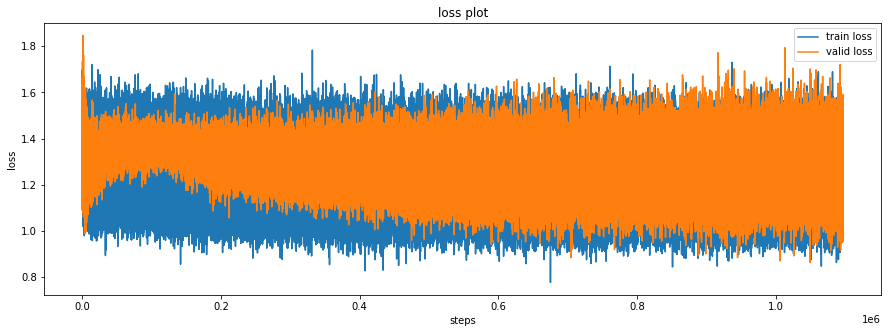

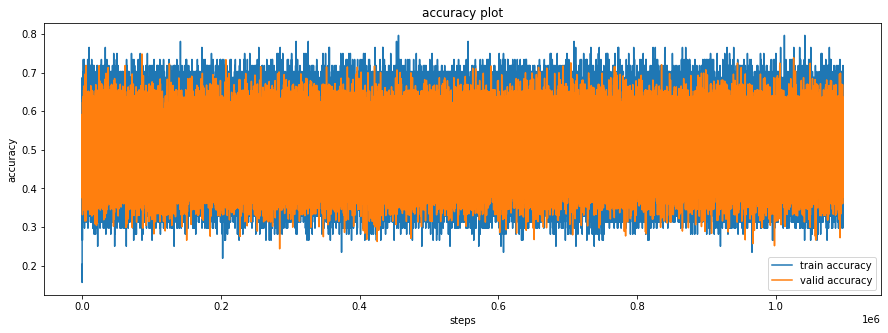

In [35]:
losses = model_trainer.losses
accuracy = model_trainer.accuracy

plot(losses, "loss", interpolate_to=len(losses["train"]))
plot(accuracy, "accuracy", interpolate_to=len(accuracy["train"]))

In [36]:
min(losses['valid'])

0.8448966145515442

In [37]:
max(accuracy['valid'])

0.75

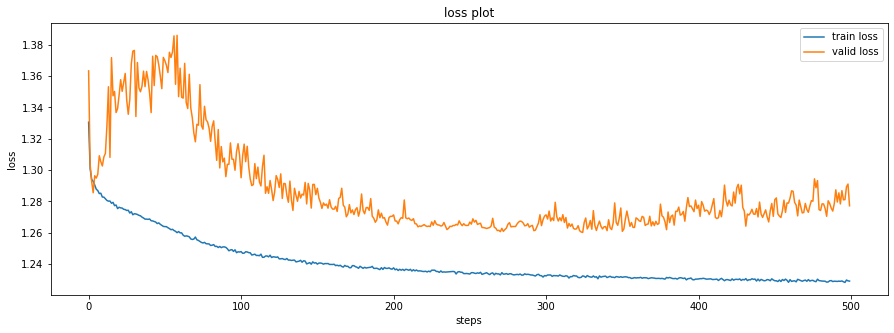

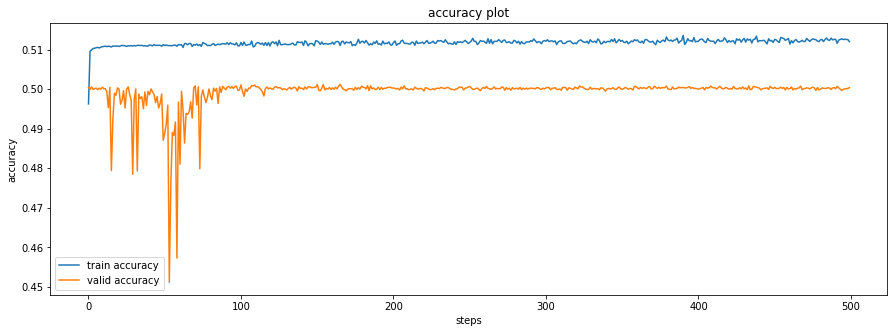

In [38]:
losses = model_trainer.epoch_losses
accuracy = model_trainer.epoch_accuracy

plot(losses, "loss", interpolate_to=len(losses["train"]))
plot(accuracy, "accuracy", interpolate_to=len(accuracy["train"]))

